In [1]:
import numpy as np
import pickle
import itertools
from tqdm import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from torchvision import transforms
from SegDataset import SegmentationDataset
from einops import rearrange
from transformers import AdamW, SegformerForSemanticSegmentation, SegformerConfig
import matplotlib.pyplot as plt
import random

import torch
from torch.utils.data import DataLoader
from torch import nn
from torch.utils.data import DataLoader

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Config

In [ ]:
DATASET_DIRECTORY = "ml-mangrove-data/"
#PRETRAINED_MODEL_NAME = "nvidia/mit-b5"
PRETRAINED_MODEL_NAME = "segformer-b5-finetuned-mangrove-128-128-15p" #alternative pretrained_model_name = "nvidia/mit-b0"
#PRETRAINED_MODEL_NAME ="./segformer-b3-finetuned-mangrove-128-128-15p/" 


DEVICE = "cuda" if torch.cuda.is_available() else "cpu" #device to be used for training and evaluation
PIN_MEMORY = True if DEVICE == "cuda" else False #if we will be pinning memory during data loading

INPUT_IMAGE_WIDTH = 128 #or 256
INPUT_IMAGE_HEIGHT = 128
NUM_CHANNELS = 9
NUM_CLASSES = 1

TEST_SPLIT = 0.10
PERCENT_NOMANGROVE_TILE_KEEP = 0.15 #percent of empty mangrove tiles to keep
BATCH_SIZE = 32
INIT_LR = 0.0002 #0.0001 #0.00006
# LOSS_FUNCTION = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([1.0, 1.0]))
NUM_EPOCHS = 2
TEST_EVAL_EVERY_BATCH = 1 #how frequently to compute/save/display test accuracy, must be non-zero positive

EARLY_STOPPER_PATIENCE = 3 #how many epochs of lower test set accuracy before early stopping (also dependent on delta)
EARLY_STOPPER_DELTA = 0 #how much test set accuracy needs to drop before early stopping (also dependent on patience)

Read Files

In [ ]:
#read data from https://www.kaggle.com/datasets/stanleydil/e4e-jamaica-segmentation-dataset by read from kaggle
with open(DATASET_DIRECTORY + '128px_images.pkl', 'rb') as handle:
    images = pickle.load(handle)

with open(DATASET_DIRECTORY + '128px_labels.pkl', 'rb') as handle:
    labels = pickle.load(handle)

with open(DATASET_DIRECTORY + '128_mlabels.pkl', 'rb') as handle:
    m_tiles = pickle.load(handle)

KeyboardInterrupt: 

Data Preprocessing

In [ ]:
#rearrange dimensions of images and labels
images = np.array(images)
images = rearrange(images, "b w h c -> b c w h")

labels = np.array(labels)
labels = rearrange(labels, "b w h c -> b c w h")
labels = np.squeeze(labels, axis=1)

print(f'input shape (b x c x w x h): {images.shape}')
print(f'label shape (b x [squeezed 1 channel] x w x h): {labels.shape}')

input shape (b x c x w x h): (4092, 9, 128, 128)
label shape (b x [squeezed 1 channel] x w x h): (4092, 128, 128)


In [ ]:
# images = np.concatenate((images[:750], images[1000:]), axis=0)
# labels = np.concatenate((labels[:750], labels[1000:]), axis=0)

trainImages, testImages, trainMasks, testMasks = train_test_split(images, labels,
                         test_size=TEST_SPLIT, random_state=42)

#systemic undersampling of 0 class
mask_sums = trainMasks.sum(axis=(1, 2))
non_empty_indices = mask_sums > 0

non_empty_indices_ls = non_empty_indices.tolist()
non_empty_indices = []
for element in non_empty_indices_ls:
    if element == False:
        if random.random() < PERCENT_NOMANGROVE_TILE_KEEP:
            non_empty_indices.append(True)
        else:
            non_empty_indices.append(False)
    else:
          non_empty_indices.append(True)

trainImages = trainImages[non_empty_indices]
trainMasks = trainMasks[non_empty_indices]


# define transformations
transforms = transforms.Compose([transforms.ToPILImage(),
                                 transforms.Resize((INPUT_IMAGE_HEIGHT,
                                                    INPUT_IMAGE_WIDTH)),
                                 transforms.ToTensor()])
# create the train and test datasets
trainDS = SegmentationDataset(images=trainImages, labels=trainMasks, transforms = transforms)
                              #transforms=transforms)
testDS = SegmentationDataset(images=testImages, labels=testMasks, transforms = transforms)
                             #transforms=transforms)
# testwithheldDS = SegmentationDataset(images=images[750:1000], labels=labels[750:1000], transforms = transforms)
#                              #transforms=transforms)

print(f"found {len(trainDS)} examples in the training set.")
print(f"found {len(testDS)} examples in the test set.")

# create the training and test data loaders #config
trainLoader = DataLoader(trainDS, shuffle=True,
                         batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY,
                         num_workers=0) #os.cpu_count()
testLoader = DataLoader(testDS, shuffle=False,
                        batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY,
                        num_workers=0) #os.cpu_count()
# testwithheldLoader = DataLoader(testwithheldDS, shuffle=False,
#                         batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY,
#                         num_workers=0) #os.cpu_count()

found 1392 examples in the training set.
found 410 examples in the test set.


In [ ]:
# assign the human-readable labels to encoding, encoding to human-readable labels
id2label = {
    0: "nomangrove",
    1: "mangrove"
}

label2id = {
    "nomangrove": 0,
    "mangrove": 1
}

Initialize Model

In [ ]:
# config = SegformerConfig.from_pretrained(PRETRAINED_MODEL_NAME)
# config.id2label = id2label
# config.label2id = label2id

# Load the pretrained model
model = SegformerForSemanticSegmentation.from_pretrained(
    PRETRAINED_MODEL_NAME,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
    num_labels = 2,
    num_channels = 9
)

# Modify the first layer to match the number of channels in data
# modified_layer = nn.Conv2d(NUM_CHANNELS, 64, kernel_size=7, stride=4, padding=3)
# model.segformer.encoder.patch_embeddings[0].proj = modified_layer

In [ ]:
print(model)

SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(9, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)

Helper Classes

In [ ]:
batch = next(iter(trainLoader))
test_batch = itertools.cycle(testLoader)
# val_batch = itertools.cycle(testwithheldLoader)

In [ ]:
optimizer = AdamW(model.parameters(), lr=INIT_LR)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Model Initialized!")

/home/mpham/.local/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Model Initialized!


In [ ]:
class Early_stopper: #early stopper class -> move to py file
    def __init__(self):
        self.patience = EARLY_STOPPER_PATIENCE
        self.delta = EARLY_STOPPER_DELTA
        self.patience_counter = 0
        self.min_test_loss = np.inf
    def check_stop(self, test_loss):
        if self.min_test_loss > test_loss:
            self.patience_counter = 0
            self.min_test_loss = test_loss
        elif test_loss > (self.min_test_loss + self.delta):
            self.patience_counter += 1
            if self.patience_counter >= self.patience:
                return True
        return False

In [ ]:
class Total_updater:
  def __init__(self):
    self.test_epoch = [] 
    self.test_acc = [] 
    self.test_avr_acc = [] 
    self.test_loss = [] 
    self.test_avr_loss = [] 
    self.test_avr_acc_epoch = []
    self.test_avr_loss_epoch = []
    self.tests_count = 0 
    self.tests_epoch_count = 0 

    self.train_epoch = []
    self.train_acc = []
    self.train_avr_acc = []
    self.train_loss = []
    self.train_avr_loss = []
    self.train_avr_acc_epoch = []
    self.train_avr_loss_epoch = []
    self.trains_count = 0
    self.trains_epoch_count = 0


    self.epoch_test_acc_cum = 0 #use
    self.total_test_acc_cum = 0 #use
    self.epoch_test_loss_cum = 0 #use
    self.total_test_loss_cum = 0 #use

    self.epoch_train_acc_cum = 0
    self.total_train_acc_cum = 0
    self.epoch_train_loss_cum = 0
    self.total_train_loss_cum = 0

    self.epoch = 0
  def update_test(self, acc, loss):
    self.tests_count += 1
    self.tests_epoch_count += 1
    self.test_epoch.append(self.epoch + TEST_EVAL_EVERY_BATCH * self.tests_epoch_count/(len(trainDS) // BATCH_SIZE + 1 ))#self.epoch + (self.tests_epoch_count-1)/self.tests_epoch_count)

    self.test_acc.append(acc)
    self.test_acc.append(loss)

    self.epoch_test_acc_cum += acc
    self.total_test_acc_cum += acc
    self.epoch_test_loss_cum += loss
    self.total_test_loss_cum += loss

    self.test_avr_acc.append(self.total_test_acc_cum/self.tests_count)
    self.test_avr_loss.append(self.total_test_loss_cum/self.tests_count)

  def update_train(self, acc, loss):
    self.trains_count += 1
    self.trains_epoch_count += 1
    self.train_epoch.append(self.epoch + self.trains_epoch_count/(len(trainDS) // BATCH_SIZE + 1 )) #(self.epoch + (self.trains_epoch_count-1)/self.trains_epoch_count)

    self.train_acc.append(acc)
    self.train_acc.append(loss)

    self.epoch_train_acc_cum += acc
    self.total_train_acc_cum += acc
    self.epoch_train_loss_cum += loss
    self.total_train_loss_cum += loss

    self.train_avr_acc.append(self.total_train_acc_cum/self.trains_count)
    self.train_avr_loss.append(self.total_train_loss_cum/self.trains_count)


  def reset_epoch(self):
    self.test_avr_acc_epoch.append(self.epoch_test_acc_cum/self.tests_epoch_count)
    self.test_avr_loss_epoch.append(self.epoch_test_loss_cum/self.tests_epoch_count)

    self.train_avr_acc_epoch.append(self.epoch_train_acc_cum/self.trains_epoch_count)
    self.train_avr_loss_epoch.append(self.epoch_train_loss_cum/self.trains_epoch_count)
    
    print(f"EPOCH {self.epoch} Avr Test Accuracy: {self.test_avr_acc_epoch[self.epoch]}\
         Avr Test Loss: {self.test_avr_loss_epoch[self.epoch]}\
         Avr Train Accuracy: {self.train_avr_acc_epoch[self.epoch]}\
         Avr Train Loss: {self.train_avr_loss_epoch[self.epoch]}")
    
    
    self.epoch_test_acc_cum = 0
    self.epoch_test_loss_cum = 0
    self.epoch_train_acc_cum = 0
    self.epoch_train_loss_cum = 0

    self.tests_epoch_count = 0
    self.trains_epoch_count = 0

    self.epoch += 1



In [ ]:
early_stopper = Early_stopper()
total_updater = Total_updater()

Train

In [ ]:
for epoch in range(NUM_EPOCHS):
    print("Epoch:", epoch)
    pbar = tqdm(trainLoader)
    model.train()
    
    total_train_set = []
    for idx, batch in enumerate(pbar):
        batch_index = idx

        # get the inputs
        pixel_values = batch[0].to(device)
        labels = batch[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        outputs = model(pixel_values=pixel_values, labels=labels)

        #train set eval
        upsampled_logits = nn.functional.interpolate(outputs.logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
        predicted = upsampled_logits.argmax(dim=1)
        mask = (labels != -1) # don't include the background class in the accuracy calculation
        pred_labels = predicted[mask].detach().cpu().numpy()
        true_labels = labels[mask].detach().cpu().numpy()
        accuracy = accuracy_score(pred_labels, true_labels)
        loss = outputs.loss

        # probabilities = torch.sigmoid(upsampled_logits)
        # logits_flat = upsampled_logits.reshape(-1, 2)  # Reshape logits to [batch_size * height * width, num_classes]
        # labels_one_hot = nn.functional.one_hot(labels.view(-1), num_classes=2)
        # loss_fn = nn.BCEWithLogitsLoss().cuda()
        # loss = loss_fn(logits_flat, labels_one_hot.float())

        total_updater.update_train(accuracy, loss.item())
        pbar.set_postfix({'Batch': idx, 'Batch Train Accuracy': accuracy, 'Train Loss': loss.item()})

        #test set eval
        if idx//TEST_EVAL_EVERY_BATCH == idx/TEST_EVAL_EVERY_BATCH:
            model.eval()
            with torch.no_grad():
                next_test_batch = next(test_batch)
                test_pixel_values = next_test_batch[0].to(device)
                test_labels = next_test_batch[1].to(device)
                test_outputs = model(pixel_values=test_pixel_values, labels=test_labels)
                test_upsampled_logits = nn.functional.interpolate(test_outputs.logits, size=test_labels.shape[-2:], mode="bilinear", align_corners=False)
                test_predicted = test_upsampled_logits.argmax(dim=1)
                test_mask = (test_labels != -1) # don't include the background class in the accuracy calculation
                test_pred_labels = test_predicted[test_mask].detach().cpu().numpy()
                test_true_labels = test_labels[test_mask].detach().cpu().numpy()
                test_accuracy = accuracy_score(test_pred_labels, test_true_labels)
                test_loss = test_outputs.loss

                total_updater.update_test(test_accuracy, test_loss.item())
                
                print(f'Batch Test Accuracy: {test_accuracy}, Test Loss: {test_loss.item()}')
                model.train()


        # backward + optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
         

    total_updater.reset_epoch()

    #early stopping
    test_loss_epoch = total_updater.test_avr_loss_epoch[total_updater.epoch-1]
    if early_stopper.check_stop(test_loss_epoch):             
        break

Epoch: 0


  0%|          | 0/44 [00:36<?, ?it/s, Batch=0, Batch Train Accuracy=0.944, Train Loss=0.127]

Batch Test Accuracy: 0.9852733612060547, Test Loss: 0.034739524126052856


  2%|▏         | 1/44 [00:47<31:55, 44.55s/it, Batch=1, Batch Train Accuracy=0.958, Train Loss=0.105]

Batch Test Accuracy: 0.9645576477050781, Test Loss: 0.10089891403913498


  5%|▍         | 2/44 [00:54<15:35, 22.28s/it, Batch=2, Batch Train Accuracy=0.925, Train Loss=0.174]

Batch Test Accuracy: 0.9788284301757812, Test Loss: 0.0613882914185524


  7%|▋         | 3/44 [01:01<10:30, 15.38s/it, Batch=3, Batch Train Accuracy=0.953, Train Loss=0.112]

Batch Test Accuracy: 0.9833240509033203, Test Loss: 0.04260510951280594


  9%|▉         | 4/44 [01:07<07:58, 11.97s/it, Batch=4, Batch Train Accuracy=0.935, Train Loss=0.151]

Batch Test Accuracy: 0.9783401489257812, Test Loss: 0.05215800553560257


 11%|█▏        | 5/44 [01:13<06:28,  9.96s/it, Batch=5, Batch Train Accuracy=0.951, Train Loss=0.113]

Batch Test Accuracy: 0.9823703765869141, Test Loss: 0.04159397631883621


 14%|█▎        | 6/44 [01:19<05:17,  8.37s/it, Batch=6, Batch Train Accuracy=0.936, Train Loss=0.15] 

Batch Test Accuracy: 0.9883823394775391, Test Loss: 0.02768760174512863


 16%|█▌        | 7/44 [01:25<04:41,  7.60s/it, Batch=7, Batch Train Accuracy=0.947, Train Loss=0.125]

Batch Test Accuracy: 0.9751758575439453, Test Loss: 0.05466495826840401


 18%|█▊        | 8/44 [01:32<04:20,  7.24s/it, Batch=8, Batch Train Accuracy=0.946, Train Loss=0.126]

Batch Test Accuracy: 0.9832935333251953, Test Loss: 0.038472067564725876


 20%|██        | 9/44 [01:38<04:07,  7.07s/it, Batch=9, Batch Train Accuracy=0.942, Train Loss=0.136]

Batch Test Accuracy: 0.9746894836425781, Test Loss: 0.0578685887157917


 23%|██▎       | 10/44 [01:43<03:41,  6.53s/it, Batch=10, Batch Train Accuracy=0.957, Train Loss=0.101]

Batch Test Accuracy: 0.9734687805175781, Test Loss: 0.060713037848472595


 25%|██▌       | 11/44 [01:50<03:32,  6.43s/it, Batch=11, Batch Train Accuracy=0.933, Train Loss=0.155]

Batch Test Accuracy: 0.9883651733398438, Test Loss: 0.029387539252638817


 27%|██▋       | 12/44 [01:55<03:20,  6.26s/it, Batch=12, Batch Train Accuracy=0.963, Train Loss=0.0864]

Batch Test Accuracy: 0.9915654109074519, Test Loss: 0.021560080349445343


 30%|██▉       | 13/44 [02:01<03:05,  5.98s/it, Batch=13, Batch Train Accuracy=0.961, Train Loss=0.0919]

Batch Test Accuracy: 0.984619140625, Test Loss: 0.03645319119095802


 32%|███▏      | 14/44 [02:06<02:53,  5.77s/it, Batch=14, Batch Train Accuracy=0.936, Train Loss=0.149] 

Batch Test Accuracy: 0.9725475311279297, Test Loss: 0.06269911676645279


 36%|███▋      | 16/44 [02:14<02:33,  5.50s/it, Batch=15, Batch Train Accuracy=0.954, Train Loss=0.108]

Batch Test Accuracy: 0.9819316864013672, Test Loss: 0.04215783625841141


 36%|███▋      | 16/44 [02:17<02:33,  5.50s/it, Batch=16, Batch Train Accuracy=0.957, Train Loss=0.1]  

Batch Test Accuracy: 0.9851932525634766, Test Loss: 0.034389346837997437


 39%|███▊      | 17/44 [02:22<02:23,  5.33s/it, Batch=17, Batch Train Accuracy=0.939, Train Loss=0.141]

Batch Test Accuracy: 0.9795684814453125, Test Loss: 0.04698387533426285


 41%|████      | 18/44 [02:29<02:31,  5.83s/it, Batch=18, Batch Train Accuracy=0.952, Train Loss=0.109]

Batch Test Accuracy: 0.9812850952148438, Test Loss: 0.04275831580162048


 43%|████▎     | 19/44 [02:34<02:22,  5.71s/it, Batch=19, Batch Train Accuracy=0.936, Train Loss=0.149]

Batch Test Accuracy: 0.9883613586425781, Test Loss: 0.02756892703473568


 45%|████▌     | 20/44 [02:40<02:16,  5.69s/it, Batch=20, Batch Train Accuracy=0.943, Train Loss=0.134]

Batch Test Accuracy: 0.9753818511962891, Test Loss: 0.05555852875113487


 48%|████▊     | 21/44 [02:49<02:19,  6.05s/it, Batch=21, Batch Train Accuracy=0.942, Train Loss=0.134]

Batch Test Accuracy: 0.9826927185058594, Test Loss: 0.03946119546890259


 50%|█████     | 22/44 [02:56<02:33,  7.00s/it, Batch=22, Batch Train Accuracy=0.948, Train Loss=0.121]

Batch Test Accuracy: 0.9748802185058594, Test Loss: 0.05713975802063942


 55%|█████▍    | 24/44 [03:08<02:23,  7.17s/it, Batch=23, Batch Train Accuracy=0.949, Train Loss=0.118]

Batch Test Accuracy: 0.9777507781982422, Test Loss: 0.05149019509553909


 55%|█████▍    | 24/44 [03:10<02:23,  7.17s/it, Batch=24, Batch Train Accuracy=0.932, Train Loss=0.153]

Batch Test Accuracy: 0.9883861541748047, Test Loss: 0.027016671374440193


 57%|█████▋    | 25/44 [03:16<02:07,  6.73s/it, Batch=25, Batch Train Accuracy=0.941, Train Loss=0.136]

Batch Test Accuracy: 0.9916616586538461, Test Loss: 0.020514588803052902


 59%|█████▉    | 26/44 [03:20<01:56,  6.45s/it, Batch=26, Batch Train Accuracy=0.957, Train Loss=0.0984]

Batch Test Accuracy: 0.9854450225830078, Test Loss: 0.033591128885746


 61%|██████▏   | 27/44 [03:24<01:36,  5.67s/it, Batch=27, Batch Train Accuracy=0.946, Train Loss=0.125] 

Batch Test Accuracy: 0.9730777740478516, Test Loss: 0.06135089322924614


 64%|██████▎   | 28/44 [03:27<01:16,  4.80s/it, Batch=28, Batch Train Accuracy=0.947, Train Loss=0.122]

Batch Test Accuracy: 0.9818878173828125, Test Loss: 0.04199159890413284


 68%|██████▊   | 30/44 [03:29<00:45,  3.25s/it, Batch=29, Batch Train Accuracy=0.945, Train Loss=0.128]

Batch Test Accuracy: 0.9849834442138672, Test Loss: 0.034838806837797165


 68%|██████▊   | 30/44 [03:30<00:45,  3.25s/it, Batch=30, Batch Train Accuracy=0.952, Train Loss=0.112]

Batch Test Accuracy: 0.9799232482910156, Test Loss: 0.046541791409254074


 73%|███████▎  | 32/44 [03:33<00:29,  2.50s/it, Batch=31, Batch Train Accuracy=0.944, Train Loss=0.129]

Batch Test Accuracy: 0.9819869995117188, Test Loss: 0.04071126878261566


 75%|███████▌  | 33/44 [03:35<00:27,  2.50s/it, Batch=32, Batch Train Accuracy=0.956, Train Loss=0.102]

Batch Test Accuracy: 0.9885158538818359, Test Loss: 0.027021674439311028


 77%|███████▋  | 34/44 [03:38<00:24,  2.41s/it, Batch=33, Batch Train Accuracy=0.943, Train Loss=0.132]

Batch Test Accuracy: 0.97528076171875, Test Loss: 0.05481291189789772


 80%|███████▉  | 35/44 [03:40<00:22,  2.53s/it, Batch=34, Batch Train Accuracy=0.935, Train Loss=0.149]

Batch Test Accuracy: 0.9829463958740234, Test Loss: 0.038765955716371536


 82%|████████▏ | 36/44 [03:43<00:20,  2.56s/it, Batch=35, Batch Train Accuracy=0.941, Train Loss=0.134]

Batch Test Accuracy: 0.9750804901123047, Test Loss: 0.05685397982597351


 82%|████████▏ | 36/44 [03:44<00:20,  2.56s/it, Batch=36, Batch Train Accuracy=0.948, Train Loss=0.12] 

Batch Test Accuracy: 0.9783515930175781, Test Loss: 0.050258297473192215


 84%|████████▍ | 37/44 [03:46<00:17,  2.47s/it, Batch=37, Batch Train Accuracy=0.949, Train Loss=0.116]

Batch Test Accuracy: 0.9885177612304688, Test Loss: 0.02714267000555992


 86%|████████▋ | 38/44 [03:49<00:13,  2.29s/it, Batch=38, Batch Train Accuracy=0.956, Train Loss=0.101]

Batch Test Accuracy: 0.9917508638822116, Test Loss: 0.020862029865384102


 91%|█████████ | 40/44 [03:52<00:09,  2.36s/it, Batch=39, Batch Train Accuracy=0.947, Train Loss=0.12] 

Batch Test Accuracy: 0.9854717254638672, Test Loss: 0.03324991464614868


 93%|█████████▎| 41/44 [03:55<00:07,  2.35s/it, Batch=40, Batch Train Accuracy=0.953, Train Loss=0.108]

Batch Test Accuracy: 0.9734821319580078, Test Loss: 0.06077011302113533


 95%|█████████▌| 42/44 [03:58<00:05,  2.67s/it, Batch=41, Batch Train Accuracy=0.945, Train Loss=0.126]

Batch Test Accuracy: 0.982147216796875, Test Loss: 0.041407082229852676


 98%|█████████▊| 43/44 [04:01<00:02,  2.65s/it, Batch=42, Batch Train Accuracy=0.937, Train Loss=0.142]

Batch Test Accuracy: 0.9852886199951172, Test Loss: 0.03394937887787819


 98%|█████████▊| 43/44 [04:04<00:02,  2.65s/it, Batch=43, Batch Train Accuracy=0.959, Train Loss=0.0943]

Batch Test Accuracy: 0.979888916015625, Test Loss: 0.046039171516895294


100%|██████████| 44/44 [04:09<00:00,  5.66s/it, Batch=43, Batch Train Accuracy=0.959, Train Loss=0.0943]


EPOCH 0 Avr Test Accuracy: 0.9814982080793047         Avr Test Loss: 0.04359290702268481         Avr Train Accuracy: 0.9463645761663263         Avr Train Loss: 0.12416060438210313
Epoch: 1


  2%|▏         | 1/44 [00:08<06:19,  8.83s/it, Batch=0, Batch Train Accuracy=0.956, Train Loss=0.103]

Batch Test Accuracy: 0.981719970703125, Test Loss: 0.040774159133434296


  2%|▏         | 1/44 [00:11<06:19,  8.83s/it, Batch=1, Batch Train Accuracy=0.952, Train Loss=0.11] 

Batch Test Accuracy: 0.9890193939208984, Test Loss: 0.025826532393693924


  7%|▋         | 3/44 [00:17<03:28,  5.07s/it, Batch=2, Batch Train Accuracy=0.933, Train Loss=0.154]

Batch Test Accuracy: 0.9763031005859375, Test Loss: 0.052802350372076035


  7%|▋         | 3/44 [00:18<03:28,  5.07s/it, Batch=3, Batch Train Accuracy=0.952, Train Loss=0.11] 

Batch Test Accuracy: 0.9836502075195312, Test Loss: 0.037124790251255035


  9%|▉         | 4/44 [00:21<02:55,  4.38s/it, Batch=4, Batch Train Accuracy=0.955, Train Loss=0.104]

Batch Test Accuracy: 0.9750404357910156, Test Loss: 0.0567752867937088


 14%|█▎        | 6/44 [00:25<02:08,  3.38s/it, Batch=5, Batch Train Accuracy=0.942, Train Loss=0.137]

Batch Test Accuracy: 0.9779567718505859, Test Loss: 0.05123906210064888


 16%|█▌        | 7/44 [00:28<01:56,  3.14s/it, Batch=6, Batch Train Accuracy=0.942, Train Loss=0.133]

Batch Test Accuracy: 0.9888381958007812, Test Loss: 0.026496266946196556


 18%|█▊        | 8/44 [00:31<01:48,  3.02s/it, Batch=7, Batch Train Accuracy=0.943, Train Loss=0.131]

Batch Test Accuracy: 0.9918118990384616, Test Loss: 0.020231273025274277


 20%|██        | 9/44 [00:34<01:43,  2.95s/it, Batch=8, Batch Train Accuracy=0.953, Train Loss=0.109]

Batch Test Accuracy: 0.9842281341552734, Test Loss: 0.03800390660762787


 20%|██        | 9/44 [00:35<01:43,  2.95s/it, Batch=9, Batch Train Accuracy=0.942, Train Loss=0.132]

Batch Test Accuracy: 0.9708309173583984, Test Loss: 0.06932279467582703


 25%|██▌       | 11/44 [00:40<01:41,  3.06s/it, Batch=10, Batch Train Accuracy=0.952, Train Loss=0.115]

Batch Test Accuracy: 0.9817714691162109, Test Loss: 0.04228666424751282


 25%|██▌       | 11/44 [00:41<01:41,  3.06s/it, Batch=11, Batch Train Accuracy=0.928, Train Loss=0.165]

Batch Test Accuracy: 0.9849128723144531, Test Loss: 0.034562334418296814


 27%|██▋       | 12/44 [00:44<01:33,  2.93s/it, Batch=12, Batch Train Accuracy=0.942, Train Loss=0.133]

Batch Test Accuracy: 0.9787826538085938, Test Loss: 0.04892841354012489


 30%|██▉       | 13/44 [00:46<01:24,  2.73s/it, Batch=13, Batch Train Accuracy=0.966, Train Loss=0.0832]

Batch Test Accuracy: 0.982666015625, Test Loss: 0.039473485201597214


 34%|███▍      | 15/44 [00:50<01:20,  2.77s/it, Batch=14, Batch Train Accuracy=0.955, Train Loss=0.108] 

Batch Test Accuracy: 0.9883995056152344, Test Loss: 0.026968562975525856


 36%|███▋      | 16/44 [00:53<01:17,  2.77s/it, Batch=15, Batch Train Accuracy=0.955, Train Loss=0.103]

Batch Test Accuracy: 0.9733734130859375, Test Loss: 0.060486357659101486


 39%|███▊      | 17/44 [00:55<01:10,  2.60s/it, Batch=16, Batch Train Accuracy=0.949, Train Loss=0.118]

Batch Test Accuracy: 0.9825344085693359, Test Loss: 0.03998776152729988


 41%|████      | 18/44 [00:58<01:08,  2.64s/it, Batch=17, Batch Train Accuracy=0.948, Train Loss=0.12] 

Batch Test Accuracy: 0.9751796722412109, Test Loss: 0.05669564753770828


 43%|████▎     | 19/44 [01:00<01:03,  2.55s/it, Batch=18, Batch Train Accuracy=0.944, Train Loss=0.128]

Batch Test Accuracy: 0.9779071807861328, Test Loss: 0.05088360980153084


 43%|████▎     | 19/44 [01:01<01:03,  2.55s/it, Batch=19, Batch Train Accuracy=0.947, Train Loss=0.124]

Batch Test Accuracy: 0.9878005981445312, Test Loss: 0.0300565455108881


 45%|████▌     | 20/44 [01:04<00:58,  2.42s/it, Batch=20, Batch Train Accuracy=0.96, Train Loss=0.0995]

Batch Test Accuracy: 0.9910325270432693, Test Loss: 0.024208515882492065


 48%|████▊     | 21/44 [01:07<00:57,  2.49s/it, Batch=21, Batch Train Accuracy=0.954, Train Loss=0.106]

Batch Test Accuracy: 0.9848003387451172, Test Loss: 0.03714204579591751


 50%|█████     | 22/44 [01:09<00:54,  2.47s/it, Batch=22, Batch Train Accuracy=0.932, Train Loss=0.157]

Batch Test Accuracy: 0.9724636077880859, Test Loss: 0.06333176791667938


 52%|█████▏    | 23/44 [01:11<00:51,  2.45s/it, Batch=23, Batch Train Accuracy=0.95, Train Loss=0.113] 

Batch Test Accuracy: 0.9820442199707031, Test Loss: 0.04208851233124733


 57%|█████▋    | 25/44 [01:14<00:43,  2.30s/it, Batch=24, Batch Train Accuracy=0.957, Train Loss=0.0994]

Batch Test Accuracy: 0.9849014282226562, Test Loss: 0.03556647524237633


 59%|█████▉    | 26/44 [01:17<00:41,  2.30s/it, Batch=25, Batch Train Accuracy=0.955, Train Loss=0.104] 

Batch Test Accuracy: 0.9800815582275391, Test Loss: 0.04600446671247482


 59%|█████▉    | 26/44 [01:18<00:41,  2.30s/it, Batch=26, Batch Train Accuracy=0.954, Train Loss=0.109]

Batch Test Accuracy: 0.9831600189208984, Test Loss: 0.03811448812484741


 64%|██████▎   | 28/44 [01:21<00:37,  2.33s/it, Batch=27, Batch Train Accuracy=0.948, Train Loss=0.121]

Batch Test Accuracy: 0.9889698028564453, Test Loss: 0.02565501630306244


 64%|██████▎   | 28/44 [01:22<00:37,  2.33s/it, Batch=28, Batch Train Accuracy=0.945, Train Loss=0.124]

Batch Test Accuracy: 0.9753932952880859, Test Loss: 0.053817398846149445


 66%|██████▌   | 29/44 [01:26<00:37,  2.49s/it, Batch=29, Batch Train Accuracy=0.947, Train Loss=0.129]

Batch Test Accuracy: 0.9828433990478516, Test Loss: 0.0392267107963562


 68%|██████▊   | 30/44 [01:28<00:34,  2.45s/it, Batch=30, Batch Train Accuracy=0.931, Train Loss=0.157]

Batch Test Accuracy: 0.9750957489013672, Test Loss: 0.05691349506378174


 70%|███████   | 31/44 [01:31<00:30,  2.37s/it, Batch=31, Batch Train Accuracy=0.948, Train Loss=0.118]

Batch Test Accuracy: 0.9780635833740234, Test Loss: 0.051479458808898926


 73%|███████▎  | 32/44 [01:33<00:29,  2.44s/it, Batch=32, Batch Train Accuracy=0.913, Train Loss=0.203]

Batch Test Accuracy: 0.9890556335449219, Test Loss: 0.0264100544154644


 77%|███████▋  | 34/44 [01:35<00:21,  2.19s/it, Batch=33, Batch Train Accuracy=0.942, Train Loss=0.133]

Batch Test Accuracy: 0.9909808819110577, Test Loss: 0.022643597796559334


 77%|███████▋  | 34/44 [01:36<00:21,  2.19s/it, Batch=34, Batch Train Accuracy=0.94, Train Loss=0.136] 

Batch Test Accuracy: 0.9843521118164062, Test Loss: 0.03671988472342491


 82%|████████▏ | 36/44 [01:40<00:16,  2.11s/it, Batch=35, Batch Train Accuracy=0.957, Train Loss=0.102]

Batch Test Accuracy: 0.9724349975585938, Test Loss: 0.06320420652627945


 82%|████████▏ | 36/44 [01:41<00:16,  2.11s/it, Batch=36, Batch Train Accuracy=0.947, Train Loss=0.123]

Batch Test Accuracy: 0.9820938110351562, Test Loss: 0.04199653118848801


 84%|████████▍ | 37/44 [01:44<00:17,  2.47s/it, Batch=37, Batch Train Accuracy=0.945, Train Loss=0.128]

Batch Test Accuracy: 0.9847373962402344, Test Loss: 0.035693444311618805


 86%|████████▋ | 38/44 [01:47<00:15,  2.51s/it, Batch=38, Batch Train Accuracy=0.937, Train Loss=0.144]

Batch Test Accuracy: 0.9788055419921875, Test Loss: 0.05051910877227783


 89%|████████▊ | 39/44 [01:48<00:12,  2.44s/it, Batch=39, Batch Train Accuracy=0.946, Train Loss=0.124]

Batch Test Accuracy: 0.9825000762939453, Test Loss: 0.04049916937947273


 93%|█████████▎| 41/44 [01:52<00:06,  2.24s/it, Batch=40, Batch Train Accuracy=0.929, Train Loss=0.164]

Batch Test Accuracy: 0.9888534545898438, Test Loss: 0.026117276400327682


 95%|█████████▌| 42/44 [01:54<00:04,  2.27s/it, Batch=41, Batch Train Accuracy=0.939, Train Loss=0.14] 

Batch Test Accuracy: 0.9759101867675781, Test Loss: 0.05357944592833519


 98%|█████████▊| 43/44 [01:57<00:02,  2.35s/it, Batch=42, Batch Train Accuracy=0.958, Train Loss=0.0989]

Batch Test Accuracy: 0.9833812713623047, Test Loss: 0.037692759186029434


100%|██████████| 44/44 [01:59<00:00,  2.73s/it, Batch=43, Batch Train Accuracy=0.944, Train Loss=0.129] 

Batch Test Accuracy: 0.9748039245605469, Test Loss: 0.05739761143922806
EPOCH 1 Avr Test Accuracy: 0.9818064916383968         Avr Test Loss: 0.04215789196843451         Avr Train Accuracy: 0.9461984200911089         Avr Train Loss: 0.12458091838793321
Epoch: 2



  2%|▏         | 1/44 [00:04<03:01,  4.23s/it, Batch=0, Batch Train Accuracy=0.95, Train Loss=0.116]

Batch Test Accuracy: 0.9712257385253906, Test Loss: 0.06352792680263519


  2%|▏         | 1/44 [00:04<03:01,  4.23s/it, Batch=1, Batch Train Accuracy=0.954, Train Loss=0.105]

Batch Test Accuracy: 0.9888210296630859, Test Loss: 0.02729742042720318


  5%|▍         | 2/44 [00:07<02:16,  3.25s/it, Batch=2, Batch Train Accuracy=0.958, Train Loss=0.0993]

Batch Test Accuracy: 0.9917250413161057, Test Loss: 0.020484117791056633


  7%|▋         | 3/44 [00:09<01:47,  2.61s/it, Batch=3, Batch Train Accuracy=0.957, Train Loss=0.0995]

Batch Test Accuracy: 0.985626220703125, Test Loss: 0.03342695161700249


 11%|█▏        | 5/44 [00:13<01:33,  2.39s/it, Batch=4, Batch Train Accuracy=0.952, Train Loss=0.11]  

Batch Test Accuracy: 0.9733371734619141, Test Loss: 0.06223835423588753


 14%|█▎        | 6/44 [00:15<01:28,  2.33s/it, Batch=5, Batch Train Accuracy=0.94, Train Loss=0.139]

Batch Test Accuracy: 0.9819908142089844, Test Loss: 0.042164191603660583


 14%|█▎        | 6/44 [00:16<01:28,  2.33s/it, Batch=6, Batch Train Accuracy=0.947, Train Loss=0.124]

Batch Test Accuracy: 0.9851570129394531, Test Loss: 0.034164268523454666


 16%|█▌        | 7/44 [00:18<01:29,  2.42s/it, Batch=7, Batch Train Accuracy=0.962, Train Loss=0.0887]

Batch Test Accuracy: 0.9800262451171875, Test Loss: 0.046033650636672974


 18%|█▊        | 8/44 [00:20<01:19,  2.21s/it, Batch=8, Batch Train Accuracy=0.966, Train Loss=0.0811]

Batch Test Accuracy: 0.9815483093261719, Test Loss: 0.04183004051446915


 23%|██▎       | 10/44 [00:24<01:21,  2.39s/it, Batch=9, Batch Train Accuracy=0.929, Train Loss=0.162]

Batch Test Accuracy: 0.9880886077880859, Test Loss: 0.027470553293824196


 23%|██▎       | 10/44 [00:26<01:21,  2.39s/it, Batch=10, Batch Train Accuracy=0.925, Train Loss=0.174]

Batch Test Accuracy: 0.9757404327392578, Test Loss: 0.053806714713573456


 25%|██▌       | 11/44 [00:28<01:25,  2.60s/it, Batch=11, Batch Train Accuracy=0.949, Train Loss=0.118]

Batch Test Accuracy: 0.9832267761230469, Test Loss: 0.038006238639354706


 27%|██▋       | 12/44 [00:31<01:25,  2.68s/it, Batch=12, Batch Train Accuracy=0.934, Train Loss=0.152]

Batch Test Accuracy: 0.9747028350830078, Test Loss: 0.05792190879583359


 30%|██▉       | 13/44 [00:35<01:27,  2.84s/it, Batch=13, Batch Train Accuracy=0.945, Train Loss=0.126]

Batch Test Accuracy: 0.9776725769042969, Test Loss: 0.05335010960698128


 32%|███▏      | 14/44 [00:39<01:32,  3.08s/it, Batch=14, Batch Train Accuracy=0.946, Train Loss=0.126]

Batch Test Accuracy: 0.9891281127929688, Test Loss: 0.026395482942461967


 34%|███▍      | 15/44 [00:41<01:29,  3.07s/it, Batch=15, Batch Train Accuracy=0.957, Train Loss=0.103]

Batch Test Accuracy: 0.9918095515324519, Test Loss: 0.020520010963082314


 36%|███▋      | 16/44 [00:44<01:22,  2.94s/it, Batch=16, Batch Train Accuracy=0.929, Train Loss=0.162]

Batch Test Accuracy: 0.985260009765625, Test Loss: 0.03444088250398636


 39%|███▊      | 17/44 [00:47<01:23,  3.08s/it, Batch=17, Batch Train Accuracy=0.952, Train Loss=0.111]

Batch Test Accuracy: 0.9733695983886719, Test Loss: 0.06046515330672264


 41%|████      | 18/44 [00:50<01:19,  3.07s/it, Batch=18, Batch Train Accuracy=0.945, Train Loss=0.125]

Batch Test Accuracy: 0.9818897247314453, Test Loss: 0.041654326021671295


 43%|████▎     | 19/44 [00:53<01:13,  2.94s/it, Batch=19, Batch Train Accuracy=0.94, Train Loss=0.137] 

Batch Test Accuracy: 0.9851455688476562, Test Loss: 0.034404780715703964


 45%|████▌     | 20/44 [00:55<01:08,  2.86s/it, Batch=20, Batch Train Accuracy=0.952, Train Loss=0.11]

Batch Test Accuracy: 0.9807529449462891, Test Loss: 0.044560253620147705


 50%|█████     | 22/44 [01:00<01:00,  2.77s/it, Batch=21, Batch Train Accuracy=0.956, Train Loss=0.103]

Batch Test Accuracy: 0.9824657440185547, Test Loss: 0.039766062051057816


 50%|█████     | 22/44 [01:01<01:00,  2.77s/it, Batch=22, Batch Train Accuracy=0.95, Train Loss=0.115] 

Batch Test Accuracy: 0.9888153076171875, Test Loss: 0.025878356769680977


 52%|█████▏    | 23/44 [01:05<01:00,  2.89s/it, Batch=23, Batch Train Accuracy=0.946, Train Loss=0.127]

Batch Test Accuracy: 0.9754505157470703, Test Loss: 0.05419696867465973


 55%|█████▍    | 24/44 [01:07<01:01,  3.05s/it, Batch=24, Batch Train Accuracy=0.95, Train Loss=0.114] 

Batch Test Accuracy: 0.9832649230957031, Test Loss: 0.03808605298399925


 57%|█████▋    | 25/44 [01:10<00:54,  2.87s/it, Batch=25, Batch Train Accuracy=0.936, Train Loss=0.145]

Batch Test Accuracy: 0.9751777648925781, Test Loss: 0.05665779858827591


 61%|██████▏   | 27/44 [01:13<00:43,  2.57s/it, Batch=26, Batch Train Accuracy=0.949, Train Loss=0.118]

Batch Test Accuracy: 0.9786396026611328, Test Loss: 0.05016589164733887


 64%|██████▎   | 28/44 [01:15<00:38,  2.41s/it, Batch=27, Batch Train Accuracy=0.957, Train Loss=0.0994]

Batch Test Accuracy: 0.9890995025634766, Test Loss: 0.026059258729219437


 64%|██████▎   | 28/44 [01:16<00:38,  2.41s/it, Batch=28, Batch Train Accuracy=0.948, Train Loss=0.122] 

Batch Test Accuracy: 0.9917555588942307, Test Loss: 0.02023504115641117


 66%|██████▌   | 29/44 [01:19<00:35,  2.37s/it, Batch=29, Batch Train Accuracy=0.94, Train Loss=0.137] 

Batch Test Accuracy: 0.9854450225830078, Test Loss: 0.03397500514984131


 68%|██████▊   | 30/44 [01:22<00:34,  2.44s/it, Batch=30, Batch Train Accuracy=0.944, Train Loss=0.131]

Batch Test Accuracy: 0.9734001159667969, Test Loss: 0.06095467135310173


 70%|███████   | 31/44 [01:24<00:32,  2.50s/it, Batch=31, Batch Train Accuracy=0.955, Train Loss=0.104]

Batch Test Accuracy: 0.9821491241455078, Test Loss: 0.0413074865937233


 75%|███████▌  | 33/44 [01:28<00:27,  2.48s/it, Batch=32, Batch Train Accuracy=0.942, Train Loss=0.131]

Batch Test Accuracy: 0.9850425720214844, Test Loss: 0.03404891863465309


 75%|███████▌  | 33/44 [01:29<00:27,  2.48s/it, Batch=33, Batch Train Accuracy=0.956, Train Loss=0.102]

Batch Test Accuracy: 0.9797649383544922, Test Loss: 0.04596695676445961


 80%|███████▉  | 35/44 [01:35<00:27,  3.03s/it, Batch=34, Batch Train Accuracy=0.938, Train Loss=0.142]

Batch Test Accuracy: 0.9803047180175781, Test Loss: 0.043979596346616745


 80%|███████▉  | 35/44 [01:36<00:27,  3.03s/it, Batch=35, Batch Train Accuracy=0.937, Train Loss=0.145]

Batch Test Accuracy: 0.9887981414794922, Test Loss: 0.02609686553478241


 82%|████████▏ | 36/44 [01:39<00:25,  3.15s/it, Batch=36, Batch Train Accuracy=0.965, Train Loss=0.0816]

Batch Test Accuracy: 0.9766139984130859, Test Loss: 0.052158255130052567


 86%|████████▋ | 38/44 [01:43<00:17,  2.86s/it, Batch=37, Batch Train Accuracy=0.945, Train Loss=0.127] 

Batch Test Accuracy: 0.9837818145751953, Test Loss: 0.03672349080443382


 86%|████████▋ | 38/44 [01:45<00:17,  2.86s/it, Batch=38, Batch Train Accuracy=0.955, Train Loss=0.104]

Batch Test Accuracy: 0.9752960205078125, Test Loss: 0.05618247017264366


 91%|█████████ | 40/44 [01:49<00:10,  2.71s/it, Batch=39, Batch Train Accuracy=0.956, Train Loss=0.1]  

Batch Test Accuracy: 0.9786605834960938, Test Loss: 0.04997951537370682


 93%|█████████▎| 41/44 [01:51<00:07,  2.61s/it, Batch=40, Batch Train Accuracy=0.936, Train Loss=0.148]

Batch Test Accuracy: 0.9886455535888672, Test Loss: 0.026672817766666412


 95%|█████████▌| 42/44 [01:53<00:05,  2.54s/it, Batch=41, Batch Train Accuracy=0.933, Train Loss=0.154]

Batch Test Accuracy: 0.9919621394230769, Test Loss: 0.01971800997853279


 98%|█████████▊| 43/44 [01:56<00:02,  2.56s/it, Batch=42, Batch Train Accuracy=0.951, Train Loss=0.112]

Batch Test Accuracy: 0.9855308532714844, Test Loss: 0.03315264731645584


100%|██████████| 44/44 [02:00<00:00,  2.73s/it, Batch=43, Batch Train Accuracy=0.94, Train Loss=0.135] 

Batch Test Accuracy: 0.9738693237304688, Test Loss: 0.05932338908314705
EPOCH 2 Avr Test Accuracy: 0.9822767764538317         Avr Test Loss: 0.040805655997246504         Avr Train Accuracy: 0.9470838199962269         Avr Train Loss: 0.12191669084131718
Epoch: 3



  2%|▏         | 1/44 [00:04<03:29,  4.87s/it, Batch=0, Batch Train Accuracy=0.952, Train Loss=0.109]

Batch Test Accuracy: 0.9822406768798828, Test Loss: 0.04113827273249626


  2%|▏         | 1/44 [00:05<03:29,  4.87s/it, Batch=1, Batch Train Accuracy=0.933, Train Loss=0.15] 

Batch Test Accuracy: 0.9850444793701172, Test Loss: 0.034032054245471954


  5%|▍         | 2/44 [00:08<02:25,  3.45s/it, Batch=2, Batch Train Accuracy=0.929, Train Loss=0.164]

Batch Test Accuracy: 0.9809455871582031, Test Loss: 0.044008612632751465


  7%|▋         | 3/44 [00:10<02:01,  2.96s/it, Batch=3, Batch Train Accuracy=0.947, Train Loss=0.122]

Batch Test Accuracy: 0.9823017120361328, Test Loss: 0.039383526891469955


  9%|▉         | 4/44 [00:13<01:44,  2.61s/it, Batch=4, Batch Train Accuracy=0.934, Train Loss=0.149]

Batch Test Accuracy: 0.9889774322509766, Test Loss: 0.025606490671634674


 14%|█▎        | 6/44 [00:16<01:35,  2.51s/it, Batch=5, Batch Train Accuracy=0.948, Train Loss=0.121]

Batch Test Accuracy: 0.975738525390625, Test Loss: 0.053230203688144684


 16%|█▌        | 7/44 [00:19<01:38,  2.65s/it, Batch=6, Batch Train Accuracy=0.954, Train Loss=0.109]

Batch Test Accuracy: 0.9835968017578125, Test Loss: 0.03718956559896469


 16%|█▌        | 7/44 [00:20<01:38,  2.65s/it, Batch=7, Batch Train Accuracy=0.954, Train Loss=0.107]

Batch Test Accuracy: 0.9750556945800781, Test Loss: 0.05645909532904625


 18%|█▊        | 8/44 [00:22<01:28,  2.47s/it, Batch=8, Batch Train Accuracy=0.943, Train Loss=0.13] 

Batch Test Accuracy: 0.9787845611572266, Test Loss: 0.04933837056159973


 20%|██        | 9/44 [00:25<01:25,  2.44s/it, Batch=9, Batch Train Accuracy=0.95, Train Loss=0.116]

Batch Test Accuracy: 0.9888706207275391, Test Loss: 0.026181722059845924


 23%|██▎       | 10/44 [00:28<01:28,  2.61s/it, Batch=10, Batch Train Accuracy=0.941, Train Loss=0.138]

Batch Test Accuracy: 0.9919198843149039, Test Loss: 0.020084334537386894


 25%|██▌       | 11/44 [00:31<01:32,  2.80s/it, Batch=11, Batch Train Accuracy=0.942, Train Loss=0.131]

Batch Test Accuracy: 0.9851417541503906, Test Loss: 0.03399934619665146


 27%|██▋       | 12/44 [00:34<01:27,  2.73s/it, Batch=12, Batch Train Accuracy=0.944, Train Loss=0.131]

Batch Test Accuracy: 0.9731349945068359, Test Loss: 0.06108556315302849


 30%|██▉       | 13/44 [00:37<01:29,  2.87s/it, Batch=13, Batch Train Accuracy=0.956, Train Loss=0.102]

Batch Test Accuracy: 0.9820232391357422, Test Loss: 0.04176827147603035


 32%|███▏      | 14/44 [00:40<01:22,  2.75s/it, Batch=14, Batch Train Accuracy=0.952, Train Loss=0.109]

Batch Test Accuracy: 0.9849433898925781, Test Loss: 0.03431037813425064


 36%|███▋      | 16/44 [00:43<01:13,  2.61s/it, Batch=15, Batch Train Accuracy=0.965, Train Loss=0.081]

Batch Test Accuracy: 0.9805984497070312, Test Loss: 0.044744428247213364


 39%|███▊      | 17/44 [00:46<01:11,  2.67s/it, Batch=16, Batch Train Accuracy=0.953, Train Loss=0.11] 

Batch Test Accuracy: 0.9824028015136719, Test Loss: 0.039781782776117325


 41%|████      | 18/44 [00:49<01:09,  2.68s/it, Batch=17, Batch Train Accuracy=0.942, Train Loss=0.133]

Batch Test Accuracy: 0.9888992309570312, Test Loss: 0.025647081434726715


 43%|████▎     | 19/44 [00:52<01:09,  2.79s/it, Batch=18, Batch Train Accuracy=0.952, Train Loss=0.112]

Batch Test Accuracy: 0.9763393402099609, Test Loss: 0.05291735380887985


 45%|████▌     | 20/44 [00:55<01:07,  2.80s/it, Batch=19, Batch Train Accuracy=0.941, Train Loss=0.133]

Batch Test Accuracy: 0.9834556579589844, Test Loss: 0.037976015359163284


 48%|████▊     | 21/44 [00:58<01:09,  3.01s/it, Batch=20, Batch Train Accuracy=0.953, Train Loss=0.106]

Batch Test Accuracy: 0.9749946594238281, Test Loss: 0.05729418247938156


 50%|█████     | 22/44 [01:01<01:04,  2.93s/it, Batch=21, Batch Train Accuracy=0.962, Train Loss=0.0859]

Batch Test Accuracy: 0.9782447814941406, Test Loss: 0.05270173400640488


 52%|█████▏    | 23/44 [01:03<00:56,  2.71s/it, Batch=22, Batch Train Accuracy=0.956, Train Loss=0.103] 

Batch Test Accuracy: 0.9886837005615234, Test Loss: 0.026967503130435944


 55%|█████▍    | 24/44 [01:05<00:52,  2.62s/it, Batch=23, Batch Train Accuracy=0.951, Train Loss=0.115]

Batch Test Accuracy: 0.9916006234975961, Test Loss: 0.020731734111905098


 55%|█████▍    | 24/44 [01:07<00:52,  2.62s/it, Batch=24, Batch Train Accuracy=0.954, Train Loss=0.108]

Batch Test Accuracy: 0.9852066040039062, Test Loss: 0.03473379835486412


 57%|█████▋    | 25/44 [01:10<00:53,  2.80s/it, Batch=25, Batch Train Accuracy=0.946, Train Loss=0.126]

Batch Test Accuracy: 0.9735908508300781, Test Loss: 0.060243211686611176


 59%|█████▉    | 26/44 [01:13<00:52,  2.92s/it, Batch=26, Batch Train Accuracy=0.946, Train Loss=0.123]

Batch Test Accuracy: 0.9821376800537109, Test Loss: 0.04197998344898224


 61%|██████▏   | 27/44 [01:15<00:47,  2.77s/it, Batch=27, Batch Train Accuracy=0.94, Train Loss=0.136] 

Batch Test Accuracy: 0.9848918914794922, Test Loss: 0.03496667742729187


 66%|██████▌   | 29/44 [01:19<00:36,  2.46s/it, Batch=28, Batch Train Accuracy=0.949, Train Loss=0.118]

Batch Test Accuracy: 0.9798679351806641, Test Loss: 0.04699453338980675


 66%|██████▌   | 29/44 [01:20<00:36,  2.46s/it, Batch=29, Batch Train Accuracy=0.944, Train Loss=0.13] 

Batch Test Accuracy: 0.9827060699462891, Test Loss: 0.03960608318448067


 68%|██████▊   | 30/44 [01:22<00:35,  2.53s/it, Batch=30, Batch Train Accuracy=0.954, Train Loss=0.105]

Batch Test Accuracy: 0.9888973236083984, Test Loss: 0.026046426966786385


 73%|███████▎  | 32/44 [01:26<00:28,  2.36s/it, Batch=31, Batch Train Accuracy=0.947, Train Loss=0.123]

Batch Test Accuracy: 0.9744300842285156, Test Loss: 0.05658164620399475


 73%|███████▎  | 32/44 [01:27<00:28,  2.36s/it, Batch=32, Batch Train Accuracy=0.947, Train Loss=0.124]

Batch Test Accuracy: 0.9834060668945312, Test Loss: 0.03872590512037277


 75%|███████▌  | 33/44 [01:30<00:26,  2.41s/it, Batch=33, Batch Train Accuracy=0.935, Train Loss=0.148]

Batch Test Accuracy: 0.9751968383789062, Test Loss: 0.05665460228919983


 77%|███████▋  | 34/44 [01:32<00:25,  2.56s/it, Batch=34, Batch Train Accuracy=0.923, Train Loss=0.214]

Batch Test Accuracy: 0.9369029998779297, Test Loss: 0.16553400456905365


 82%|████████▏ | 36/44 [01:36<00:21,  2.63s/it, Batch=35, Batch Train Accuracy=0.954, Train Loss=0.113]

Batch Test Accuracy: 0.9882125854492188, Test Loss: 0.02862899750471115


 84%|████████▍ | 37/44 [01:39<00:17,  2.54s/it, Batch=36, Batch Train Accuracy=0.94, Train Loss=0.139] 

Batch Test Accuracy: 0.9875089205228366, Test Loss: 0.03175366297364235


 86%|████████▋ | 38/44 [01:41<00:14,  2.42s/it, Batch=37, Batch Train Accuracy=0.889, Train Loss=0.359]

Batch Test Accuracy: 0.9729175567626953, Test Loss: 0.0864964947104454


 89%|████████▊ | 39/44 [01:44<00:12,  2.50s/it, Batch=38, Batch Train Accuracy=0.929, Train Loss=0.164]

Batch Test Accuracy: 0.9099140167236328, Test Loss: 0.2555754780769348


 91%|█████████ | 40/44 [01:47<00:10,  2.69s/it, Batch=39, Batch Train Accuracy=0.918, Train Loss=0.185]

Batch Test Accuracy: 0.9280376434326172, Test Loss: 0.18622593581676483


 93%|█████████▎| 41/44 [01:49<00:08,  2.69s/it, Batch=40, Batch Train Accuracy=0.905, Train Loss=0.204]

Batch Test Accuracy: 0.9680938720703125, Test Loss: 0.0854765996336937


 95%|█████████▌| 42/44 [01:52<00:05,  2.55s/it, Batch=41, Batch Train Accuracy=0.925, Train Loss=0.178]

Batch Test Accuracy: 0.9228134155273438, Test Loss: 0.17529301345348358


 95%|█████████▌| 42/44 [01:53<00:05,  2.55s/it, Batch=42, Batch Train Accuracy=0.933, Train Loss=0.157]

Batch Test Accuracy: 0.9768199920654297, Test Loss: 0.05651737377047539


 98%|█████████▊| 43/44 [01:56<00:02,  2.60s/it, Batch=43, Batch Train Accuracy=0.903, Train Loss=0.228]

Batch Test Accuracy: 0.97430419921875, Test Loss: 0.06210369989275932


100%|██████████| 44/44 [01:58<00:00,  2.69s/it, Batch=43, Batch Train Accuracy=0.903, Train Loss=0.228]


EPOCH 3 Avr Test Accuracy: 0.976358980565638         Avr Test Loss: 0.05742535799403082         Avr Train Accuracy: 0.9416738856922496         Avr Train Loss: 0.1375687039372596
Epoch: 4


  2%|▏         | 1/44 [00:04<03:27,  4.81s/it, Batch=0, Batch Train Accuracy=0.917, Train Loss=0.208]

Batch Test Accuracy: 0.94403076171875, Test Loss: 0.16663378477096558


  5%|▍         | 2/44 [00:07<02:23,  3.42s/it, Batch=1, Batch Train Accuracy=0.93, Train Loss=0.162] 

Batch Test Accuracy: 0.9277629852294922, Test Loss: 0.45009052753448486


  7%|▋         | 3/44 [00:09<01:57,  2.86s/it, Batch=2, Batch Train Accuracy=0.89, Train Loss=0.378]

Batch Test Accuracy: 0.9693584442138672, Test Loss: 0.07247074693441391


  7%|▋         | 3/44 [00:10<01:57,  2.86s/it, Batch=3, Batch Train Accuracy=0.917, Train Loss=0.193]

Batch Test Accuracy: 0.9614791870117188, Test Loss: 0.09084450453519821


  9%|▉         | 4/44 [00:13<01:53,  2.83s/it, Batch=4, Batch Train Accuracy=0.922, Train Loss=0.195]

Batch Test Accuracy: 0.9324893951416016, Test Loss: 0.1684069037437439


 11%|█▏        | 5/44 [00:15<01:44,  2.69s/it, Batch=5, Batch Train Accuracy=0.929, Train Loss=0.196]

Batch Test Accuracy: 0.1078350360576923, Test Loss: 2.8782434463500977


 14%|█▎        | 6/44 [00:18<01:41,  2.66s/it, Batch=6, Batch Train Accuracy=0.894, Train Loss=0.255]

Batch Test Accuracy: 0.13207054138183594, Test Loss: 2.2848961353302


 18%|█▊        | 8/44 [00:21<01:27,  2.44s/it, Batch=7, Batch Train Accuracy=0.954, Train Loss=0.124]

Batch Test Accuracy: 0.7927989959716797, Test Loss: 0.5223191380500793


 18%|█▊        | 8/44 [00:23<01:27,  2.44s/it, Batch=8, Batch Train Accuracy=0.941, Train Loss=0.143]

Batch Test Accuracy: 0.9429149627685547, Test Loss: 0.1673533171415329


 23%|██▎       | 10/44 [00:26<01:19,  2.34s/it, Batch=9, Batch Train Accuracy=0.919, Train Loss=0.203]

Batch Test Accuracy: 0.9795761108398438, Test Loss: 0.050926677882671356


 25%|██▌       | 11/44 [00:28<01:18,  2.38s/it, Batch=10, Batch Train Accuracy=0.922, Train Loss=0.192]

Batch Test Accuracy: 0.9730243682861328, Test Loss: 0.0687408521771431


 27%|██▋       | 12/44 [00:31<01:13,  2.29s/it, Batch=11, Batch Train Accuracy=0.918, Train Loss=0.187]

Batch Test Accuracy: 0.9782619476318359, Test Loss: 0.054836321622133255


 27%|██▋       | 12/44 [00:31<01:13,  2.29s/it, Batch=12, Batch Train Accuracy=0.94, Train Loss=0.145] 

Batch Test Accuracy: 0.98248291015625, Test Loss: 0.04872393235564232


 30%|██▉       | 13/44 [00:33<01:07,  2.19s/it, Batch=13, Batch Train Accuracy=0.942, Train Loss=0.145]

Batch Test Accuracy: 0.9720420837402344, Test Loss: 0.08102641254663467


 34%|███▍      | 15/44 [00:38<01:08,  2.37s/it, Batch=14, Batch Train Accuracy=0.93, Train Loss=0.168] 

Batch Test Accuracy: 0.9504184722900391, Test Loss: 0.1143948882818222


 34%|███▍      | 15/44 [00:39<01:08,  2.37s/it, Batch=15, Batch Train Accuracy=0.928, Train Loss=0.171]

Batch Test Accuracy: 0.9583702087402344, Test Loss: 0.14988555014133453


 36%|███▋      | 16/44 [00:41<01:09,  2.47s/it, Batch=16, Batch Train Accuracy=0.927, Train Loss=0.172]

Batch Test Accuracy: 0.9326534271240234, Test Loss: 0.15366065502166748


 41%|████      | 18/44 [00:45<01:05,  2.52s/it, Batch=17, Batch Train Accuracy=0.939, Train Loss=0.144]

Batch Test Accuracy: 0.9865875244140625, Test Loss: 0.04065431281924248


 43%|████▎     | 19/44 [00:48<01:02,  2.51s/it, Batch=18, Batch Train Accuracy=0.94, Train Loss=0.152] 

Batch Test Accuracy: 0.9878939115084134, Test Loss: 0.03525825962424278


 43%|████▎     | 19/44 [00:49<01:02,  2.51s/it, Batch=19, Batch Train Accuracy=0.944, Train Loss=0.142]

Batch Test Accuracy: 0.9829273223876953, Test Loss: 0.04546193405985832


 45%|████▌     | 20/44 [00:51<00:58,  2.44s/it, Batch=20, Batch Train Accuracy=0.932, Train Loss=0.167]

Batch Test Accuracy: 0.9612369537353516, Test Loss: 0.09306324273347855


 48%|████▊     | 21/44 [00:53<00:55,  2.41s/it, Batch=21, Batch Train Accuracy=0.933, Train Loss=0.156]

Batch Test Accuracy: 0.9748344421386719, Test Loss: 0.06162242591381073


 50%|█████     | 22/44 [00:56<00:52,  2.39s/it, Batch=22, Batch Train Accuracy=0.94, Train Loss=0.143] 

Batch Test Accuracy: 0.9815044403076172, Test Loss: 0.0457991361618042


 55%|█████▍    | 24/44 [00:59<00:46,  2.34s/it, Batch=23, Batch Train Accuracy=0.948, Train Loss=0.126]

Batch Test Accuracy: 0.9739017486572266, Test Loss: 0.06438112258911133


 57%|█████▋    | 25/44 [01:02<00:45,  2.41s/it, Batch=24, Batch Train Accuracy=0.933, Train Loss=0.159]

Batch Test Accuracy: 0.9806442260742188, Test Loss: 0.04661380127072334


 59%|█████▉    | 26/44 [01:05<00:43,  2.43s/it, Batch=25, Batch Train Accuracy=0.942, Train Loss=0.14] 

Batch Test Accuracy: 0.9878425598144531, Test Loss: 0.0309166107326746


 59%|█████▉    | 26/44 [01:05<00:43,  2.43s/it, Batch=26, Batch Train Accuracy=0.955, Train Loss=0.111]

Batch Test Accuracy: 0.9739971160888672, Test Loss: 0.06059251353144646


 61%|██████▏   | 27/44 [01:08<00:41,  2.44s/it, Batch=27, Batch Train Accuracy=0.941, Train Loss=0.145]

Batch Test Accuracy: 0.982391357421875, Test Loss: 0.041880521923303604


 66%|██████▌   | 29/44 [01:11<00:33,  2.24s/it, Batch=28, Batch Train Accuracy=0.949, Train Loss=0.122]

Batch Test Accuracy: 0.9730014801025391, Test Loss: 0.062430672347545624


 68%|██████▊   | 30/44 [01:13<00:31,  2.29s/it, Batch=29, Batch Train Accuracy=0.936, Train Loss=0.148]

Batch Test Accuracy: 0.9764919281005859, Test Loss: 0.05736182630062103


 70%|███████   | 31/44 [01:16<00:31,  2.44s/it, Batch=30, Batch Train Accuracy=0.934, Train Loss=0.156]

Batch Test Accuracy: 0.9876995086669922, Test Loss: 0.03249784931540489


 70%|███████   | 31/44 [01:18<00:31,  2.44s/it, Batch=31, Batch Train Accuracy=0.932, Train Loss=0.159]

Batch Test Accuracy: 0.9910067044771634, Test Loss: 0.024390382692217827


 73%|███████▎  | 32/44 [01:21<00:31,  2.66s/it, Batch=32, Batch Train Accuracy=0.939, Train Loss=0.141]

Batch Test Accuracy: 0.9846343994140625, Test Loss: 0.03708840161561966


 75%|███████▌  | 33/44 [01:24<00:29,  2.64s/it, Batch=33, Batch Train Accuracy=0.95, Train Loss=0.12]  

Batch Test Accuracy: 0.9723777770996094, Test Loss: 0.06422899663448334


 77%|███████▋  | 34/44 [01:27<00:28,  2.84s/it, Batch=34, Batch Train Accuracy=0.94, Train Loss=0.14]

Batch Test Accuracy: 0.9813728332519531, Test Loss: 0.04712473601102829


 80%|███████▉  | 35/44 [01:30<00:25,  2.86s/it, Batch=35, Batch Train Accuracy=0.946, Train Loss=0.129]

Batch Test Accuracy: 0.9841938018798828, Test Loss: 0.03777175769209862


 82%|████████▏ | 36/44 [01:32<00:23,  2.92s/it, Batch=36, Batch Train Accuracy=0.945, Train Loss=0.128]

Batch Test Accuracy: 0.9739704132080078, Test Loss: 0.06493411213159561


 84%|████████▍ | 37/44 [01:35<00:19,  2.83s/it, Batch=37, Batch Train Accuracy=0.936, Train Loss=0.146]

Batch Test Accuracy: 0.9793281555175781, Test Loss: 0.05423408001661301


 86%|████████▋ | 38/44 [01:38<00:15,  2.64s/it, Batch=38, Batch Train Accuracy=0.944, Train Loss=0.133]

Batch Test Accuracy: 0.9879302978515625, Test Loss: 0.03413481265306473


 89%|████████▊ | 39/44 [01:40<00:13,  2.73s/it, Batch=39, Batch Train Accuracy=0.959, Train Loss=0.102]

Batch Test Accuracy: 0.9749240875244141, Test Loss: 0.058679670095443726


 91%|█████████ | 40/44 [01:42<00:10,  2.55s/it, Batch=40, Batch Train Accuracy=0.963, Train Loss=0.0957]

Batch Test Accuracy: 0.9831333160400391, Test Loss: 0.04002954810857773


 93%|█████████▎| 41/44 [01:45<00:07,  2.57s/it, Batch=41, Batch Train Accuracy=0.943, Train Loss=0.132] 

Batch Test Accuracy: 0.9746131896972656, Test Loss: 0.05907861515879631


 95%|█████████▌| 42/44 [01:47<00:04,  2.49s/it, Batch=42, Batch Train Accuracy=0.942, Train Loss=0.137]

Batch Test Accuracy: 0.9770584106445312, Test Loss: 0.05478006973862648


100%|██████████| 44/44 [01:52<00:00,  2.55s/it, Batch=43, Batch Train Accuracy=0.938, Train Loss=0.145]

Batch Test Accuracy: 0.9882831573486328, Test Loss: 0.02998676896095276
EPOCH 4 Avr Test Accuracy: 0.9295761568562969         Avr Test Loss: 0.20110113580118527         Avr Train Accuracy: 0.9354469125921075         Avr Train Loss: 0.15806124511767516
Epoch: 5



  2%|▏         | 1/44 [00:04<02:57,  4.13s/it, Batch=0, Batch Train Accuracy=0.941, Train Loss=0.138]

Batch Test Accuracy: 0.99139404296875, Test Loss: 0.022282447665929794


  2%|▏         | 1/44 [00:05<02:57,  4.13s/it, Batch=1, Batch Train Accuracy=0.931, Train Loss=0.16] 

Batch Test Accuracy: 0.9846782684326172, Test Loss: 0.03633366525173187


  7%|▋         | 3/44 [00:08<01:52,  2.73s/it, Batch=2, Batch Train Accuracy=0.939, Train Loss=0.145]

Batch Test Accuracy: 0.9728183746337891, Test Loss: 0.06240110844373703


  7%|▋         | 3/44 [00:10<01:52,  2.73s/it, Batch=3, Batch Train Accuracy=0.953, Train Loss=0.11] 

Batch Test Accuracy: 0.9817600250244141, Test Loss: 0.04349827393889427


 11%|█▏        | 5/44 [00:13<01:36,  2.47s/it, Batch=4, Batch Train Accuracy=0.944, Train Loss=0.131]

Batch Test Accuracy: 0.9851322174072266, Test Loss: 0.03477862477302551


 14%|█▎        | 6/44 [00:15<01:28,  2.34s/it, Batch=5, Batch Train Accuracy=0.947, Train Loss=0.124]

Batch Test Accuracy: 0.9795780181884766, Test Loss: 0.048174407333135605


 16%|█▌        | 7/44 [00:17<01:23,  2.27s/it, Batch=6, Batch Train Accuracy=0.95, Train Loss=0.119] 

Batch Test Accuracy: 0.9828510284423828, Test Loss: 0.0396583192050457


 16%|█▌        | 7/44 [00:18<01:23,  2.27s/it, Batch=7, Batch Train Accuracy=0.941, Train Loss=0.138]

Batch Test Accuracy: 0.9884376525878906, Test Loss: 0.02724413201212883


 20%|██        | 9/44 [00:22<01:24,  2.42s/it, Batch=8, Batch Train Accuracy=0.954, Train Loss=0.109]

Batch Test Accuracy: 0.9758777618408203, Test Loss: 0.05372070521116257


 20%|██        | 9/44 [00:24<01:24,  2.42s/it, Batch=9, Batch Train Accuracy=0.938, Train Loss=0.142]

Batch Test Accuracy: 0.9833602905273438, Test Loss: 0.0382658988237381


 23%|██▎       | 10/44 [00:27<01:32,  2.73s/it, Batch=10, Batch Train Accuracy=0.955, Train Loss=0.106]

Batch Test Accuracy: 0.9747810363769531, Test Loss: 0.05833778902888298


 25%|██▌       | 11/44 [00:30<01:28,  2.69s/it, Batch=11, Batch Train Accuracy=0.945, Train Loss=0.13] 

Batch Test Accuracy: 0.9772472381591797, Test Loss: 0.054748404771089554


 27%|██▋       | 12/44 [00:32<01:24,  2.63s/it, Batch=12, Batch Train Accuracy=0.952, Train Loss=0.114]

Batch Test Accuracy: 0.9884071350097656, Test Loss: 0.029255101457238197


 32%|███▏      | 14/44 [00:36<01:19,  2.66s/it, Batch=13, Batch Train Accuracy=0.956, Train Loss=0.104]

Batch Test Accuracy: 0.9914668156550481, Test Loss: 0.02179892547428608


 34%|███▍      | 15/44 [00:38<01:12,  2.52s/it, Batch=14, Batch Train Accuracy=0.957, Train Loss=0.103]

Batch Test Accuracy: 0.9851188659667969, Test Loss: 0.036307573318481445


 36%|███▋      | 16/44 [00:41<01:07,  2.41s/it, Batch=15, Batch Train Accuracy=0.961, Train Loss=0.0975]

Batch Test Accuracy: 0.9736881256103516, Test Loss: 0.06165876239538193


 36%|███▋      | 16/44 [00:42<01:07,  2.41s/it, Batch=16, Batch Train Accuracy=0.942, Train Loss=0.134] 

Batch Test Accuracy: 0.9812183380126953, Test Loss: 0.04892558977007866


 41%|████      | 18/44 [00:45<01:00,  2.33s/it, Batch=17, Batch Train Accuracy=0.945, Train Loss=0.131]

Batch Test Accuracy: 0.9852218627929688, Test Loss: 0.034529417753219604


 41%|████      | 18/44 [00:46<01:00,  2.33s/it, Batch=18, Batch Train Accuracy=0.944, Train Loss=0.129]

Batch Test Accuracy: 0.9786548614501953, Test Loss: 0.05181790143251419


 43%|████▎     | 19/44 [00:48<00:56,  2.24s/it, Batch=19, Batch Train Accuracy=0.937, Train Loss=0.145]

Batch Test Accuracy: 0.9825630187988281, Test Loss: 0.040949758142232895


 45%|████▌     | 20/44 [00:51<00:56,  2.33s/it, Batch=20, Batch Train Accuracy=0.925, Train Loss=0.173]

Batch Test Accuracy: 0.9879016876220703, Test Loss: 0.02842586673796177


 48%|████▊     | 21/44 [00:54<00:55,  2.40s/it, Batch=21, Batch Train Accuracy=0.943, Train Loss=0.131]

Batch Test Accuracy: 0.9756221771240234, Test Loss: 0.05407276749610901


 50%|█████     | 22/44 [00:56<00:57,  2.63s/it, Batch=22, Batch Train Accuracy=0.947, Train Loss=0.121]

Batch Test Accuracy: 0.9832897186279297, Test Loss: 0.03780193626880646


 52%|█████▏    | 23/44 [00:59<00:53,  2.53s/it, Batch=23, Batch Train Accuracy=0.946, Train Loss=0.124]

Batch Test Accuracy: 0.9749011993408203, Test Loss: 0.05754249915480614


 55%|█████▍    | 24/44 [01:02<00:52,  2.62s/it, Batch=24, Batch Train Accuracy=0.958, Train Loss=0.0958]

Batch Test Accuracy: 0.973175048828125, Test Loss: 0.06222449243068695


 57%|█████▋    | 25/44 [01:04<00:50,  2.66s/it, Batch=25, Batch Train Accuracy=0.928, Train Loss=0.163] 

Batch Test Accuracy: 0.988525390625, Test Loss: 0.028690477833151817


 61%|██████▏   | 27/44 [01:08<00:43,  2.58s/it, Batch=26, Batch Train Accuracy=0.943, Train Loss=0.132]

Batch Test Accuracy: 0.9917813814603366, Test Loss: 0.021171076223254204


 64%|██████▎   | 28/44 [01:11<00:41,  2.58s/it, Batch=27, Batch Train Accuracy=0.947, Train Loss=0.123]

Batch Test Accuracy: 0.9852409362792969, Test Loss: 0.03471439704298973


 66%|██████▌   | 29/44 [01:13<00:38,  2.53s/it, Batch=28, Batch Train Accuracy=0.951, Train Loss=0.113]

Batch Test Accuracy: 0.97344970703125, Test Loss: 0.06084280088543892


 66%|██████▌   | 29/44 [01:15<00:38,  2.53s/it, Batch=29, Batch Train Accuracy=0.937, Train Loss=0.143]

Batch Test Accuracy: 0.9820766448974609, Test Loss: 0.04182964935898781


 68%|██████▊   | 30/44 [01:17<00:36,  2.60s/it, Batch=30, Batch Train Accuracy=0.964, Train Loss=0.087]

Batch Test Accuracy: 0.9853954315185547, Test Loss: 0.0340096578001976


 73%|███████▎  | 32/44 [01:20<00:27,  2.27s/it, Batch=31, Batch Train Accuracy=0.948, Train Loss=0.121]

Batch Test Accuracy: 0.9793891906738281, Test Loss: 0.04785677790641785


 75%|███████▌  | 33/44 [01:22<00:23,  2.18s/it, Batch=32, Batch Train Accuracy=0.945, Train Loss=0.126]

Batch Test Accuracy: 0.9824657440185547, Test Loss: 0.04028872027993202


 77%|███████▋  | 34/44 [01:25<00:22,  2.27s/it, Batch=33, Batch Train Accuracy=0.942, Train Loss=0.134]

Batch Test Accuracy: 0.9886283874511719, Test Loss: 0.026470741257071495


 77%|███████▋  | 34/44 [01:25<00:22,  2.27s/it, Batch=34, Batch Train Accuracy=0.95, Train Loss=0.115] 

Batch Test Accuracy: 0.9758567810058594, Test Loss: 0.05396594479680061


 80%|███████▉  | 35/44 [01:28<00:20,  2.25s/it, Batch=35, Batch Train Accuracy=0.956, Train Loss=0.102]

Batch Test Accuracy: 0.9834861755371094, Test Loss: 0.03747379779815674


 82%|████████▏ | 36/44 [01:30<00:18,  2.30s/it, Batch=36, Batch Train Accuracy=0.949, Train Loss=0.12] 

Batch Test Accuracy: 0.9750289916992188, Test Loss: 0.05703532695770264


 86%|████████▋ | 38/44 [01:34<00:13,  2.32s/it, Batch=37, Batch Train Accuracy=0.95, Train Loss=0.114]

Batch Test Accuracy: 0.9776763916015625, Test Loss: 0.052642326802015305


 89%|████████▊ | 39/44 [01:37<00:12,  2.42s/it, Batch=38, Batch Train Accuracy=0.943, Train Loss=0.132]

Batch Test Accuracy: 0.9881534576416016, Test Loss: 0.027621958404779434


 89%|████████▊ | 39/44 [01:38<00:12,  2.42s/it, Batch=39, Batch Train Accuracy=0.952, Train Loss=0.113]

Batch Test Accuracy: 0.9916194035456731, Test Loss: 0.021333767101168633


 91%|█████████ | 40/44 [01:41<00:10,  2.61s/it, Batch=40, Batch Train Accuracy=0.957, Train Loss=0.0995]

Batch Test Accuracy: 0.9858551025390625, Test Loss: 0.03290746733546257


 93%|█████████▎| 41/44 [01:44<00:08,  2.69s/it, Batch=41, Batch Train Accuracy=0.94, Train Loss=0.139]  

Batch Test Accuracy: 0.9732227325439453, Test Loss: 0.06087232008576393


 95%|█████████▌| 42/44 [01:46<00:05,  2.62s/it, Batch=42, Batch Train Accuracy=0.939, Train Loss=0.137]

Batch Test Accuracy: 0.9821205139160156, Test Loss: 0.041725680232048035


 98%|█████████▊| 43/44 [01:50<00:02,  2.67s/it, Batch=43, Batch Train Accuracy=0.944, Train Loss=0.131]

Batch Test Accuracy: 0.9852504730224609, Test Loss: 0.03423064202070236


100%|██████████| 44/44 [01:51<00:00,  2.55s/it, Batch=43, Batch Train Accuracy=0.944, Train Loss=0.131]

EPOCH 5 Avr Test Accuracy: 0.9821447192372141         Avr Test Loss: 0.04182813405482606         Avr Train Accuracy: 0.9462994228709828         Avr Train Loss: 0.12495864504440264


Train/Test Loss/Accuracy Plot

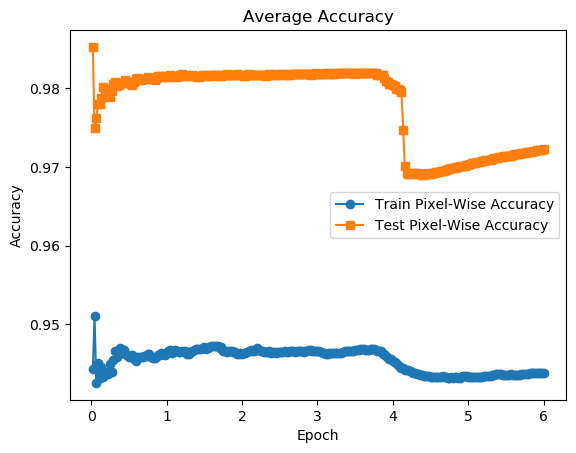

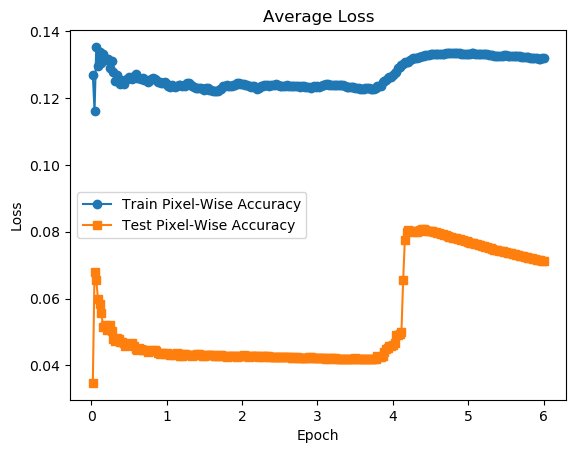

In [ ]:
plt.plot(total_updater.train_epoch, total_updater.train_avr_acc, label='Train Pixel-Wise Accuracy', marker='o', linestyle='-')
plt.plot(total_updater.test_epoch, total_updater.test_avr_acc, label='Test Pixel-Wise Accuracy', marker='s', linestyle='-')


plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Average Accuracy')

plt.legend()
plt.show()


plt.plot(total_updater.train_epoch, total_updater.train_avr_loss, label='Train Pixel-Wise Accuracy', marker='o', linestyle='-')
plt.plot(total_updater.test_epoch, total_updater.test_avr_loss, label='Test Pixel-Wise Accuracy', marker='s', linestyle='-')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Average Loss')

plt.legend()
plt.show()

Accuracy Scores

In [ ]:
print('average sample test accuracy per epoch')
total_updater.test_avr_acc_epoch

average sample test accuracy per epoch


[0.9814982080793047,
 0.9818064916383968,
 0.9822767764538317,
 0.976358980565638,
 0.9295761568562969,
 0.9821447192372141]

In [ ]:
final_test_batch_iterator = iter(testLoader)
batch_accuracies = []
tn_count = 0
fp_count = 0
fn_count = 0
tp_count = 0

while True:
    try:
        # model.eval()
        next_test_batch = next(final_test_batch_iterator)
        
        test_pixel_values = next_test_batch[0].to(device)
        test_labels = next_test_batch[1].to(device)
        test_outputs = model(pixel_values=test_pixel_values, labels=test_labels)
        test_upsampled_logits = nn.functional.interpolate(test_outputs.logits, size=test_labels.shape[-2:], mode="bilinear", align_corners=False)
        test_predicted = test_upsampled_logits.argmax(dim=1)
        test_mask = (test_labels != -1) # don't include the background class in the accuracy calculation
        test_pred_labels = test_predicted[test_mask].detach().cpu().numpy()
        test_true_labels = test_labels[test_mask].detach().cpu().numpy()
        
        test_accuracy = accuracy_score(test_pred_labels, test_true_labels)
        batch_accuracies.append(test_accuracy)

        conf_matrix = confusion_matrix(test_pred_labels, test_true_labels)
        tn, fp, fn, tp = conf_matrix.ravel()
        tn_count += tn
        fp_count += fp
        fn_count += fn
        tp_count += tp



    except StopIteration:
        break

iou = tp_count/(tp_count+fp_count+fn_count)
iou0 = tn_count/(tn_count+fn_count+fp_count)

print(f'pixel-wise accuracy: {sum(batch_accuracies)/len(batch_accuracies)}')
print(f'TN: {tn_count}, FP: {fp_count}, FN: {fn_count}, TP: {tp_count}')
print(f'precision: {tp_count/(tp_count+fp_count)}')
print(f'recall: {tp_count/(tp_count+fn_count)}')
print(f'iou (1 class): {iou}')
print(f'iou (0 class): {iou0}')
print(f'miou: {0.5*(iou+iou0)}')

pixel-wise accuracy: 0.9744840317223904
TN: 5959967, FP: 82473, FN: 89611, TP: 585389
precision: 0.8765119141379507
recall: 0.867242962962963
iou (1 class): 0.7728183050749003
iou (0 class): 0.9719369587761093
miou: 0.8723776319255048


Hugging Face Upload

In [ ]:
#model.save_pretrained("segformer-b3-finetuned-mangrove-128-128-15p") #save weights to folder

In [ ]:
# model.save_model("./my_model")

# with open('auth_token.txt', 'r') as file:
#     auth_token = file.read().strip()

# model.save_model("mpham8/segformer-b5-finetuned-mangrove-128-128", use_auth_token=auth_token)

Inference

In [ ]:
model.eval()
next_test_batch = next(test_batch)
test_pixel_values = next_test_batch[0].to(device)
test_labels = next_test_batch[1].to(device)
test_outputs = model(pixel_values=test_pixel_values, labels=test_labels)
test_upsampled_logits = nn.functional.interpolate(test_outputs.logits, size=test_labels.shape[-2:], mode="bilinear", align_corners=False)
test_predicted = test_upsampled_logits.argmax(dim=1)
test_mask = (test_labels != -1) # don't include the background class in the accuracy calculation
test_pred_labels = test_predicted[test_mask].detach().cpu().numpy()
test_true_labels = test_labels[test_mask].detach().cpu().numpy()
test_accuracy = accuracy_score(test_pred_labels, test_true_labels)

In [ ]:
reshaped_true = test_true_labels.reshape(BATCH_SIZE, INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT)
reshaped_pred = test_pred_labels.reshape(BATCH_SIZE, INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT)
rgb_pixels = test_pixel_values.detach().cpu().numpy()[:, [3,2,1],:,:]
rgb_pixels = rearrange(rgb_pixels, "b c w h -> b w h c")/np.max(rgb_pixels)

satellite image (3 bands only)


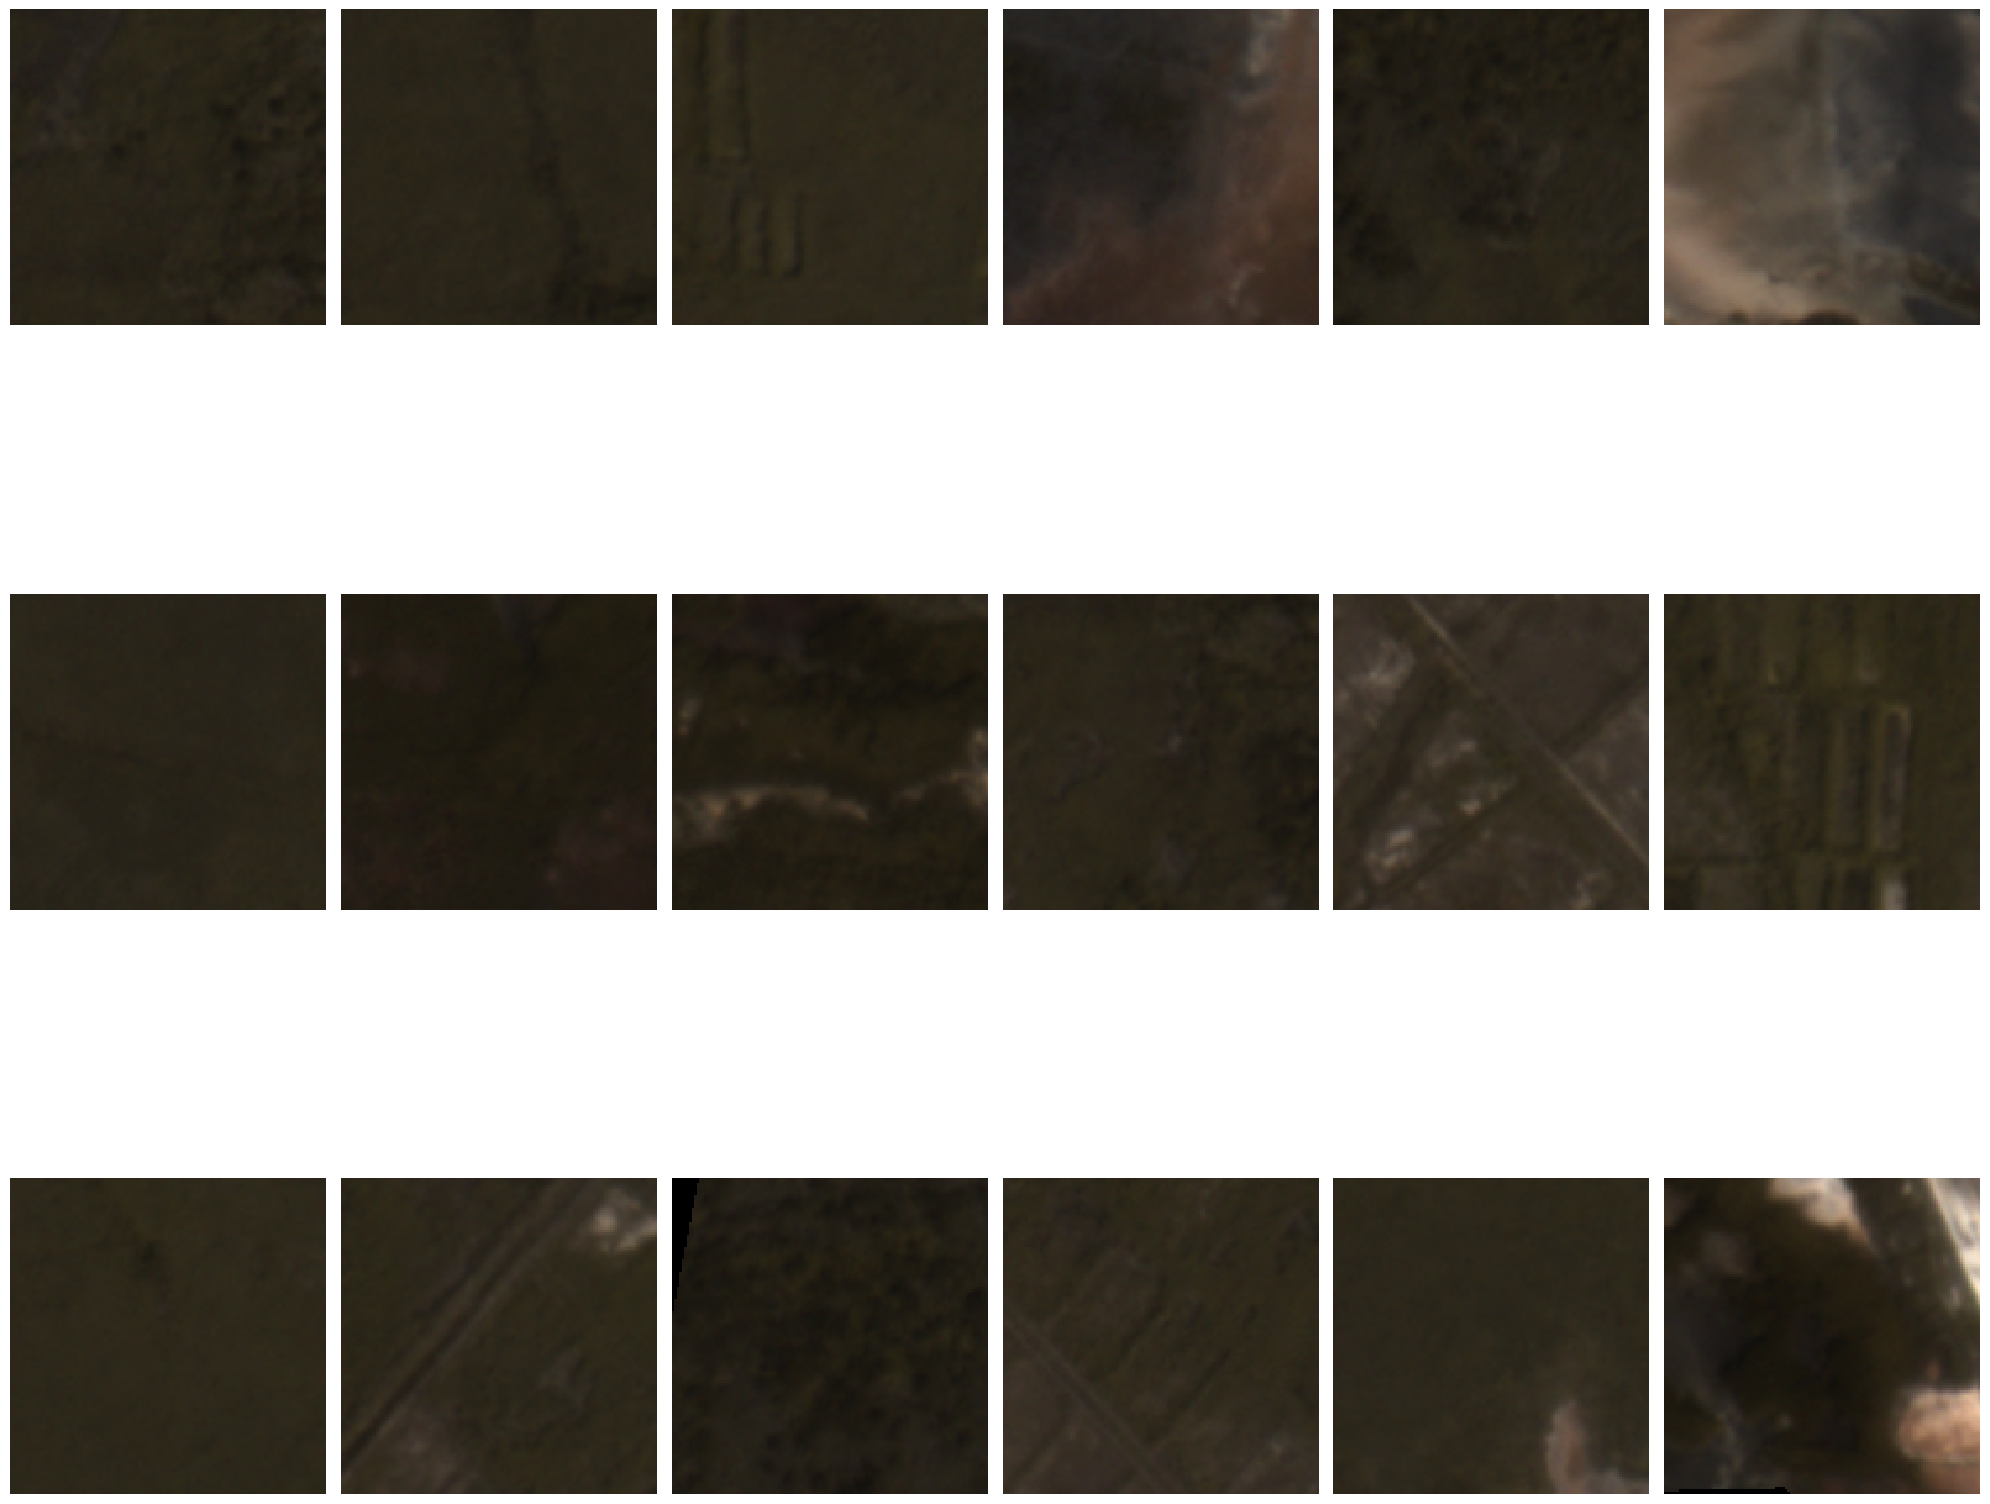

satellite image with predicted mask


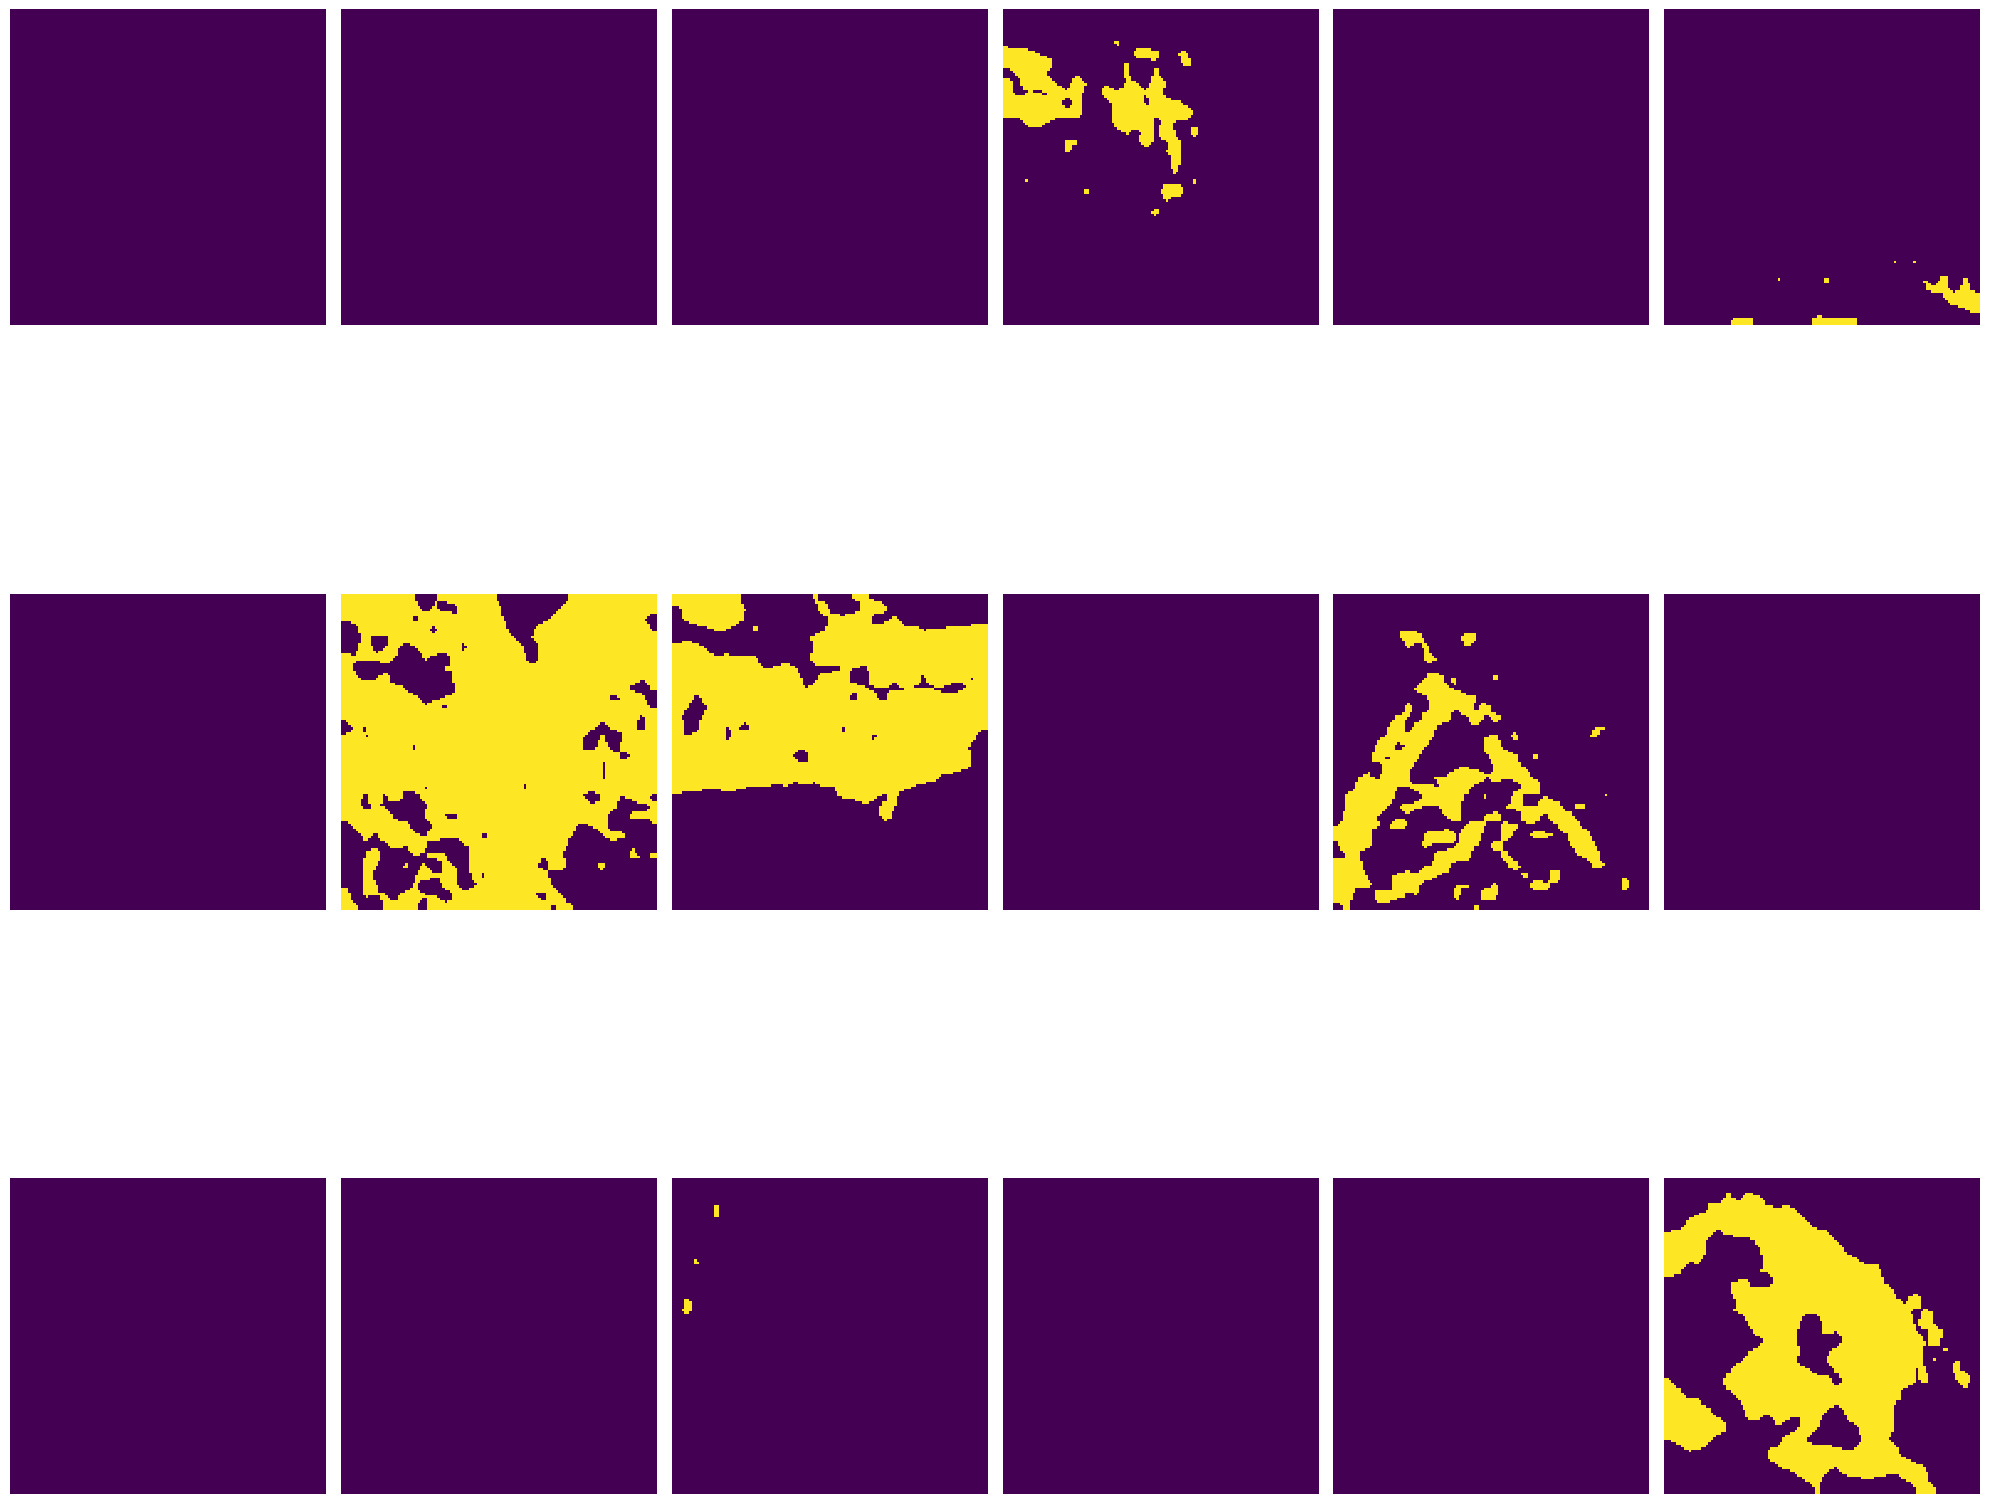

satellite image with true mask


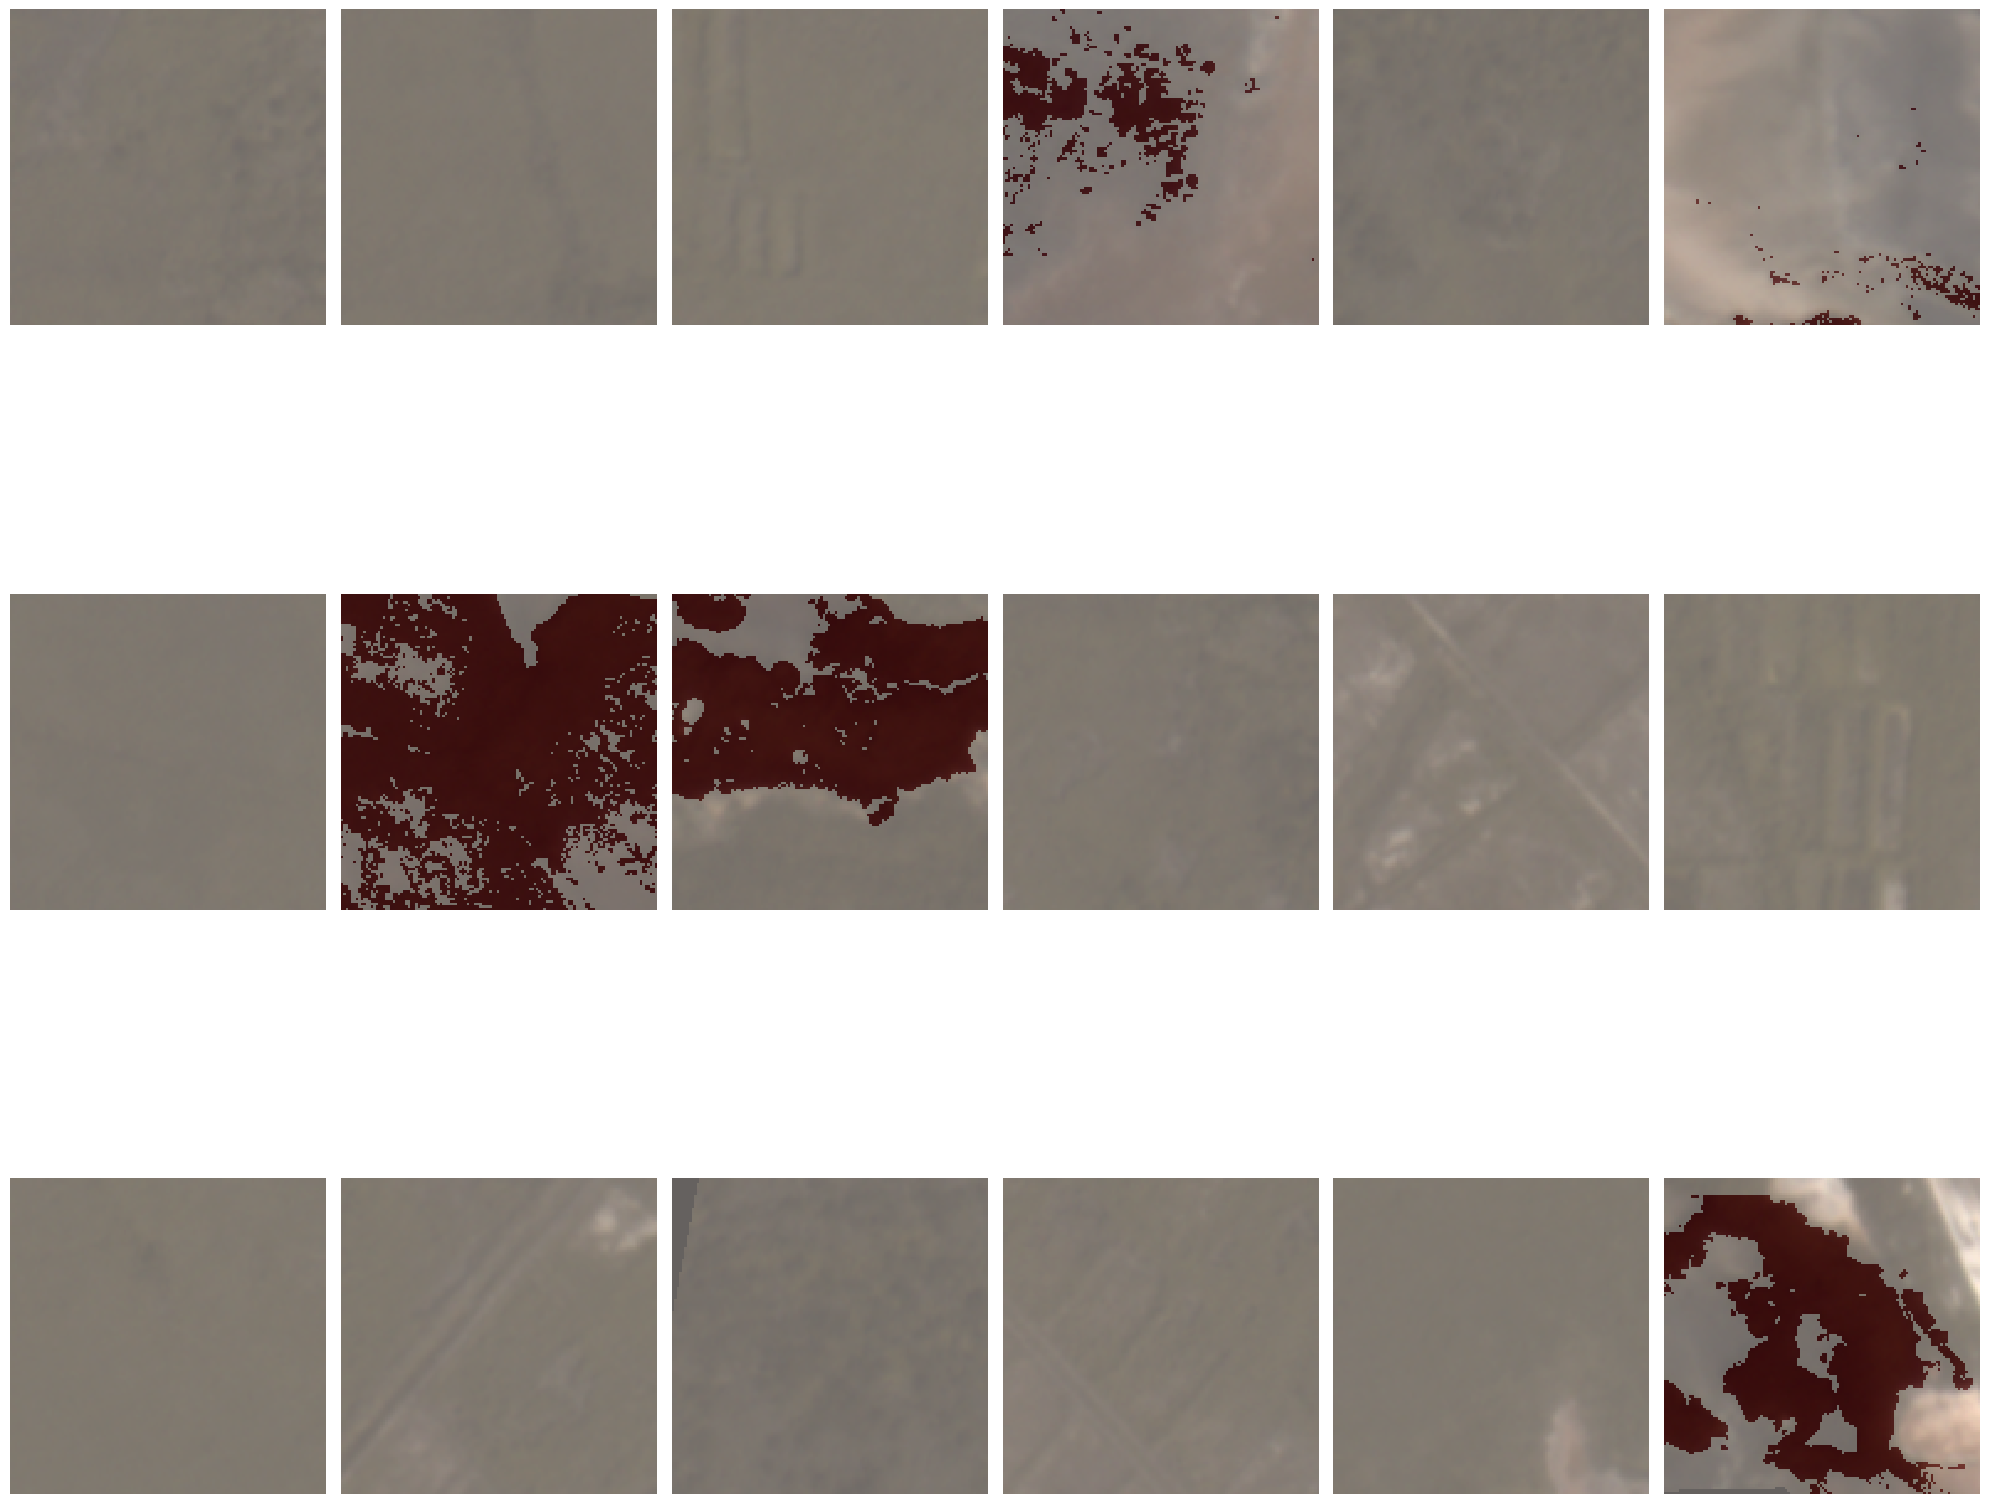

In [ ]:
num_rows = 3
num_cols = 6

print('satellite image (3 bands only)')
# Create a new figure with multiple subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20,20))

# Loop through the images and masks and display them in the subplots
for i in range(num_rows*num_cols):
    img = rgb_pixels[i]

    # Plot the image
    axes[i // num_cols, i % num_cols].imshow(img)

    # Turn off axis ticks and labels for cleaner visualization
    axes[i // num_cols, i % num_cols].axis('off')

# Display the subplots
plt.tight_layout()
plt.show()



print('satellite image with predicted mask')
# Create a new figure with multiple subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20,20))

# Loop through the images and masks and display them in the subplots
for i in range(num_rows*num_cols):
    img = rgb_pixels[i]
    mask = reshaped_pred[i]

    # Plot the image
    axes[i // num_cols, i % num_cols].imshow(img)

    # Overlay the mask on the image with transparency (alpha value)
    # If the mask is binary (0 and 1), you can set alpha=0.5 to make the mask semi-transparent
    axes[i // num_cols, i % num_cols].imshow(mask, alpha=1, cmap='viridis')

    # Turn off axis ticks and labels for cleaner visualization
    axes[i // num_cols, i % num_cols].axis('off')

# Display the subplots
plt.tight_layout()
plt.show()


print('satellite image with true mask')
# Create a new figure with multiple subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20,20))

# # Loop through the images and masks and display them in the subplots
# for i in range(num_rows*num_cols):
#     img = rgb_pixels[i]
#     mask = reshaped_true[i]

#     # Plot the image
#     axes[i // num_cols, i % num_cols].imshow(img)

#     # Overlay the mask on the image with transparency (alpha value)
#     # If the mask is binary (0 and 1), you can set alpha=0.5 to make the mask semi-transparent
#     # axes[i // num_cols, i % num_cols].imshow(mask, alpha=1, cmap='viridis')
#     axes[i // num_cols, i % num_cols].imshow(mask, cmap='Reds', alpha=0.4, vmin=0, vmax=1)


#     # Turn off axis ticks and labels for cleaner visualization
#     axes[i // num_cols, i % num_cols].axis('off')

for i in range(num_rows*num_cols):
    img = rgb_pixels[i]
    mask = reshaped_true[i]

    # Plot the image
    axes[i // num_cols, i % num_cols].imshow(img)

    # Create a mask where transparent areas have value 0 and mask areas have value 1
    mask_alpha = np.where(mask == 0, 0, 1)

    # Set the colormap for the mask to fully transparent (alpha=0) for areas without the mask
    cmap = mpl.colors.ListedColormap(['blue', 'none'])

    # Plot the mask with transparency (alpha value)
    axes[i // num_cols, i % num_cols].imshow(mask_alpha, cmap=cmap, alpha=1, vmin=0, vmax=1)

    # Turn off axis ticks and labels for cleaner visualization
    axes[i // num_cols, i % num_cols].axis('off')

# Display the subplots
plt.tight_layout()
plt.show()